# Setup

## Packages

### Installs

In [314]:
!pip install spacy
!pip install openai
!pip install convokit
!pip install NRCLex
!pip install nltk

In [383]:
!pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 1.5 MB/s eta 0:00:00


### Imports

In [384]:
import pandas as pd
import re
import spacy
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag
import getpass
import os
import openai
from openai import OpenAI
import ast
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import convokit
import random
import shutil
from scipy.spatial.distance import cosine
import numpy as np
from tabulate import tabulate
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import altair as alt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from transformers import pipeline
from nltk.sentiment import SentimentIntensityAnalyzer
from nrclex import NRCLex
from matplotlib.lines import Line2D
from sentence_transformers import SentenceTransformer

## Load/Download

In [15]:
nlp = spacy.load("en_core_web_sm")

In [16]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [216]:
nlp = spacy.load("en_core_web_sm")

## Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## OPENAI

In [49]:
OPENAI_API_KEY = getpass.getpass()

··········


In [50]:
# Set the environment variable
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

# Making dataframes

## TURNS

### Cleaning chat Log

In [34]:
TURNS = pd.read_csv('/content/drive/MyDrive/Thesis Data /processed_turns_no_dupes.csv')

In [265]:
# Counting the occurrences of each value in the 'condition' column
condition_counts = TURNS['condition'].value_counts()

# Display the counts
print("Counts of each condition:")
print(condition_counts)

Counts of each condition:
dialogue    1001
control      990
debate       690
Name: condition, dtype: int64


In [35]:
TURNS.head()

StartDate               EndDate  Status      IPAddress  \
0  2023-05-05T12:56:19Z  2023-05-05T13:09:15Z       0  63.155.15.220   
1  2023-05-05T12:56:19Z  2023-05-05T13:09:15Z       0  63.155.15.220   
2  2023-05-05T12:56:19Z  2023-05-05T13:09:15Z       0  63.155.15.220   
3  2023-05-05T12:56:19Z  2023-05-05T13:09:15Z       0  63.155.15.220   
4  2023-05-05T12:56:19Z  2023-05-05T13:09:15Z       0  63.155.15.220   

   Progress  Duration (in seconds)  Finished          RecordedDate  \
0       100                    775         1  2023-05-05T13:09:15Z   
1       100                    775         1  2023-05-05T13:09:15Z   
2       100                    775         1  2023-05-05T13:09:15Z   
3       100                    775         1  2023-05-05T13:09:15Z   
4       100                    775         1  2023-05-05T13:09:15Z   

          ResponseId  RecipientLastName  ...  Positive.Emotion  \
0  R_1DpW3cNED8SZ11N                NaN  ...                 5   
1  R_1DpW3cNED8SZ11N                NaN  ...                 5   
2  R_1DpW3cNED8SZ11N                NaN  ...                 5   
3  R_1DpW3cNED8SZ11N                NaN  ...                 5   
4  R_1DpW3cNED8SZ11N                NaN  ...                 5   

   Negative.Emotion  Questions  Gratitude  Apology Truth.Intensifier  \
0                 3          3          0        0                 0   
1                 3          3          0        0                 0   
2                 3          3          0        0                 0   
3                 3          3          0        0                 0   
4                 3          3          0        0                 0   

  Affirmation Conjunction.Start  convonumber  lineinconvo  
0           0                 0            1            1  
1           0                 0            1            2  
2           0                 0            1            3  
3           0                 0            1            4  
4           0                 0            1            5  

[5 rows x 178 columns]

In [36]:
# Remove brackets from the beginning and end of each line
TURNS['chatLog'] = TURNS['chatLog'].apply(lambda x: re.sub(r'^\[|\]$', '', x))

# Display the modified DataFrame
print(TURNS[['chatLog']])

                                                chatLog
0                                            B: Hello\n
1                                    B: anyone there?\n
2        B: Do you feel men have too much privilege? \n
3                              B: Can anyone hear me?\n
4     B: Well I will say my part then. I have person...
...                                                 ...
2676  A: My opinion is this-- I feel like Republican...
2677  A: I feel like religion and abortion don't mix...
2678  B: Policy alignment: Republicans may feel that...
2679                                      A: Right...\n
2680                                    B: yes right \n

[2681 rows x 1 columns]


In [37]:
TURNS['chatLog'] = TURNS['chatLog'].astype(str)
TURNS[['chatLog']]

chatLog
0                                            B: Hello\n
1                                    B: anyone there?\n
2        B: Do you feel men have too much privilege? \n
3                              B: Can anyone hear me?\n
4     B: Well I will say my part then. I have person...
...                                                 ...
2676  A: My opinion is this-- I feel like Republican...
2677  A: I feel like religion and abortion don't mix...
2678  B: Policy alignment: Republicans may feel that...
2679                                      A: Right...\n
2680                                    B: yes right \n

[2681 rows x 1 columns]

In [38]:
# Remove extra whitespace
TURNS['chatLog'] = TURNS['chatLog'].str.strip()

# Remove special characters and escape sequences
TURNS['chatLog'] = TURNS['chatLog'].replace(r'(<br>| |\n)', '', regex=True)

# Remove 'B:' and 'A:' prefixes
TURNS['chatLog'] = TURNS['chatLog'].str.replace(r'(B:|A:)', '', regex=True)

# Remove leading and trailing spaces
TURNS['chatLog'] = TURNS['chatLog'].str.strip()

# Display the modified DataFrame
print(TURNS[['chatLog']])

                                                chatLog
0                                                 Hello
1                                         anyone there?
2              Do you feel men have too much privilege?
3                                   Can anyone hear me?
4     Well I will say my part then. I have personall...
...                                                 ...
2676  My opinion is this-- I feel like Republicans w...
2677       I feel like religion and abortion don't mix.
2678  Policy alignment: Republicans may feel that th...
2679                                           Right...
2680                                          yes right

[2681 rows x 1 columns]


In [39]:
# Function to remove punctuation
def remove_punctuation(text):
    # Use regular expression to remove punctuation
    return re.sub(r'[^\w\s]', '', text)

# Apply the function to the 'CleanedChatLog' column
TURNS['chatLog'] = TURNS['chatLog'].apply(remove_punctuation)

print(TURNS[['chatLog']])


                                                chatLog
0                                                 Hello
1                                          anyone there
2               Do you feel men have too much privilege
3                                    Can anyone hear me
4     Well I will say my part then I have personally...
...                                                 ...
2676  My opinion is this I feel like Republicans wan...
2677         I feel like religion and abortion dont mix
2678  Policy alignment Republicans may feel that the...
2679                                              Right
2680                                          yes right

[2681 rows x 1 columns]


In [40]:
#creating a easier name to call, and making sure I have a backup
TURNS['CLEAN'] = TURNS['chatLog']

In [231]:
TURNS['CLEAN'] = TURNS['CLEAN'].apply(lambda x: x.lower())

### LEM (Lemmatize only)

In [41]:
#Functions to lemmatize using nltk, note the verb "to be" will be excluded from the lemmatization
def get_wordnet_pos(treebank_tag):
    """Converts treebank POS tags to a format recognized by the WordNetLemmatizer."""
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def lemmatize_text(text):
    # Define forms of "to be" to exclude from lemmatization
    forms_of_to_be = {"is", "am", "are", "was", "were", "be", "being", "been"}

    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    tagged_tokens = pos_tag(tokens)
    lemmatized_tokens = []

    for word, tag in tagged_tokens:
        # Exclude words that are forms of "to be"
        if word.lower() in forms_of_to_be:
            lemmatized_tokens.append(word)
        else:
            wn_tag = get_wordnet_pos(tag)
            # Lemmatize based on POS tag if available, else keep the word as is
            if wn_tag is not None:
                lemmatized_word = lemmatizer.lemmatize(word, wn_tag)
            else:
                lemmatized_word = word
            lemmatized_tokens.append(lemmatized_word)

    return " ".join(lemmatized_tokens)

# Apply the lemmatization function to the 'CleanedChatLog' column
TURNS['LEM'] = TURNS['CLEAN'].apply(lemmatize_text)


In [42]:
print(TURNS['LEM'])

0                                                   Hello
1                                            anyone there
2                 Do you feel men have too much privilege
3                                      Can anyone hear me
4       Well I will say my part then I have personally...
                              ...                        
2676    My opinion is this I feel like Republicans wan...
2677           I feel like religion and abortion dont mix
2678    Policy alignment Republicans may feel that the...
2679                                                Right
2680                                            yes right
Name: LEM, Length: 2681, dtype: object


In [61]:
# Function to tokenize, normalize text, and join tokens into a single string
def tokenize_normalize_join(text):
    tokens = word_tokenize(text)
    normalized_tokens = [token.lower() for token in tokens]
    # Joining tokens into a single string
    return ' '.join(normalized_tokens)

# Assuming TURNS is your DataFrame and it's already defined
TURNS['LEM_T'] = TURNS['LEM'].apply(tokenize_normalize_join)

# Display the DataFrame to verify the changes
print(TURNS['LEM_T'])


0                                                   hello
1                                            anyone there
2                 do you feel men have too much privilege
3                                      can anyone hear me
4       well i will say my part then i have personally...
                              ...                        
2676    my opinion is this i feel like republicans wan...
2677           i feel like religion and abortion dont mix
2678    policy alignment republicans may feel that the...
2679                                                right
2680                                            yes right
Name: LEM_T, Length: 2681, dtype: object


### STOP (only Stop Words removed)

In [43]:
# Custom list of stopwords
custom_stop_words = {"the", "a", "and", "to", "it", "of"}

# Function to remove custom stopwords from a text
def remove_custom_stopwords(text):
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word.lower() not in custom_stop_words]
    return ' '.join(filtered_tokens)

# Apply the function to the 'CLEAN' column and create the 'STOP' column
TURNS['STOP'] = TURNS['CLEAN'].apply(remove_custom_stopwords)

In [44]:
print(TURNS['STOP'])

0                                                   Hello
1                                            anyone there
2                 Do you feel men have too much privilege
3                                      Can anyone hear me
4       Well I will say my part then I have personally...
                              ...                        
2676    My opinion is this I feel like Republicans wan...
2677               I feel like religion abortion dont mix
2678    Policy alignment Republicans may feel that pol...
2679                                                Right
2680                                            yes right
Name: STOP, Length: 2681, dtype: object


### BOTH (Lemmitized + Stop Words removed)

In [45]:
# Custom list of stopwords
custom_stop_words = {"the", "a", "and", "to", "it", "of"}

# Function to remove custom stopwords from a list of tokens
def remove_custom_stopwords_from_tokens(tokens):
    return [word for word in tokens if word.lower() not in custom_stop_words]

# Function that combines lemmatization (excluding forms of "to be") and stopword removal
def lemmatize_and_remove_stopwords(text):
    forms_of_to_be = {"is", "am", "are", "was", "were", "be", "being", "been"}
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    tagged_tokens = pos_tag(tokens)
    processed_tokens = []

    for word, tag in tagged_tokens:
        # Exclude words that are forms of "to be" before lemmatization
        if word.lower() in forms_of_to_be:
            processed_tokens.append(word)
        else:
            wn_tag = get_wordnet_pos(tag)
            # Lemmatize based on POS tag if available, else keep the word as is
            if wn_tag is not None:
                lemmatized_word = lemmatizer.lemmatize(word, wn_tag)
            else:
                lemmatized_word = word
            processed_tokens.append(lemmatized_word)

    # Remove custom stopwords from the lemmatized tokens
    final_tokens = remove_custom_stopwords_from_tokens(processed_tokens)
    return " ".join(final_tokens)

# Apply the combined function to the 'CLEAN' column to create the 'BOTH' column
TURNS['BOTH'] = TURNS['CLEAN'].apply(lemmatize_and_remove_stopwords)

In [46]:
print(TURNS['BOTH'])

0                                                   Hello
1                                            anyone there
2                 Do you feel men have too much privilege
3                                      Can anyone hear me
4       Well I will say my part then I have personally...
                              ...                        
2676    My opinion is this I feel like Republicans wan...
2677               I feel like religion abortion dont mix
2678    Policy alignment Republicans may feel that pol...
2679                                                Right
2680                                            yes right
Name: BOTH, Length: 2681, dtype: object


### POS

In [414]:
import nltk
from collections import Counter

# Sample DataFrame
# Assuming you already have the DataFrame named fullconvo

# Download NLTK resources (if not already downloaded)
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Function to count verbs and question words
def count_verbs_and_question_words(text):
    # Tokenize the text
    tokens = nltk.word_tokenize(text)

    # Perform part-of-speech tagging
    pos_tags = nltk.pos_tag(tokens)

    # Initialize counters
    verb_count = 0
    question_word_count = 0

    # Count verbs and question words
    for word, tag in pos_tags:
        if tag.startswith('VB'):  # Verbs (VB, VBD, VBG, VBN, VBP, VBZ)
            verb_count += 1
        elif word.lower() in ['who', 'what', 'when', 'where', 'why', 'how']:  # Question words
            question_word_count += 1

    return verb_count, question_word_count

# Apply the function to the 'CleanedChatLog' column
TURNS['VerbCount'], TURNS['QuestionWordCount'] = zip(*TURNS['CLEAN'].apply(count_verbs_and_question_words))

# Display the modified DataFrame with counts of verbs and question words
print(TURNS[['VerbCount', 'QuestionWordCount']])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


      VerbCount  QuestionWordCount
0             0                  0
1             0                  0
2             3                  0
3             1                  0
4            13                  0
...         ...                ...
2676          5                  0
2677          1                  0
2678         10                  0
2679          0                  0
2680          0                  0

[2681 rows x 2 columns]


In [415]:
# Calculate total sum for all rows
total_verb_count_all = TURNS['VerbCount'].sum()
total_question_word_count_all = TURNS['QuestionWordCount'].sum()

# Calculate sum for rows with 'condition' equal to 'control'
control_rows = TURNS[TURNS['condition'] == 'control']
total_verb_count_control = control_rows['VerbCount'].sum()
total_question_word_count_control = control_rows['QuestionWordCount'].sum()

# Calculate sum for rows with 'condition' equal to 'dialogue'
dialogue_rows = TURNS[TURNS['condition'] == 'dialogue']
total_verb_count_dialogue = dialogue_rows['VerbCount'].sum()
total_question_word_count_dialogue = dialogue_rows['QuestionWordCount'].sum()

# Calculate sum for rows with 'condition' equal to 'debate'
debate_rows = TURNS[TURNS['condition'] == 'debate']
total_verb_count_debate = debate_rows['VerbCount'].sum()
total_question_word_count_debate = debate_rows['QuestionWordCount'].sum()

# Display the sums
print("Sum for all data:")
print("Verbs:", total_verb_count_all)
print("Question words:", total_question_word_count_all)
print("\nSum for 'control':")
print("Verbs:", total_verb_count_control)
print("Question words:", total_question_word_count_control)
print("\nSum for 'dialogue':")
print("Verbs:", total_verb_count_dialogue)
print("Question words:", total_question_word_count_dialogue)
print("\nSum for 'debate':")
print("Verbs:", total_verb_count_debate)
print("Question words:", total_question_word_count_debate)

Sum for all data:
Verbs: 8771
Question words: 783

Sum for 'control':
Verbs: 2980
Question words: 264

Sum for 'dialogue':
Verbs: 3377
Question words: 307

Sum for 'debate':
Verbs: 2414
Question words: 212


/usr/local/lib/python3.10/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.10/dist-packages/numpy/lib/histograms.py:826: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


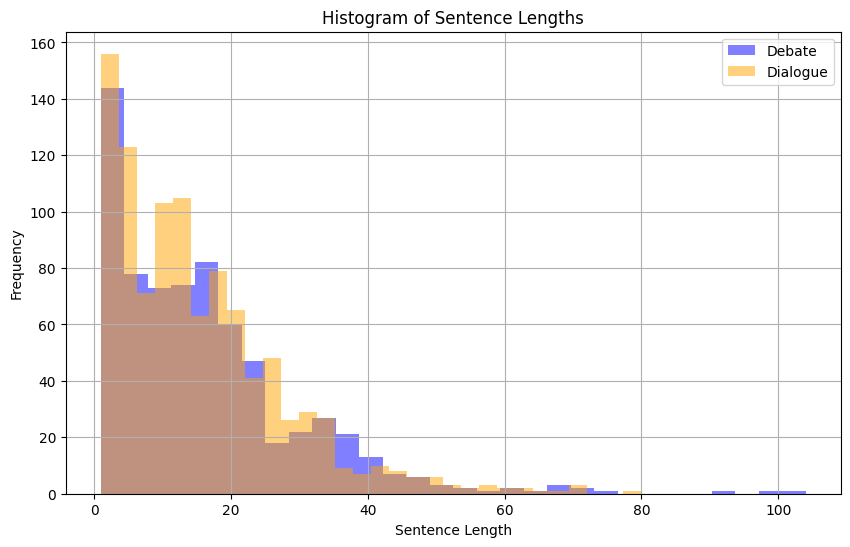

In [416]:
import matplotlib.pyplot as plt

# Function to calculate sentence lengths
def sentence_lengths(text):
    # Tokenize the text into sentences
    sentences = nltk.sent_tokenize(text)

    # Calculate the length of each sentence
    lengths = [len(nltk.word_tokenize(sentence)) for sentence in sentences]

    return lengths

# Calculate sentence lengths for 'debate' and 'dialogue' data
debate_lengths = debate_rows['CLEAN'].apply(sentence_lengths).explode()
dialogue_lengths = dialogue_rows['CLEAN'].apply(sentence_lengths).explode()

# Plot histograms
plt.figure(figsize=(10, 6))
plt.hist(debate_lengths, bins=30, alpha=0.5, label='Debate', color='blue')
plt.hist(dialogue_lengths, bins=30, alpha=0.5, label='Dialogue', color='orange')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.title('Histogram of Sentence Lengths')
plt.legend()
plt.grid(True)
plt.show()


##FULLCONVO

In [240]:
FULLCONVO = pd.read_csv('/content/drive/MyDrive/chatLog_no_dupes_pidx2.csv')

In [264]:
# Count the occurrences of each value in the 'condition' column
condition_counts = FULLCONVO['condition'].value_counts()

# Display the counts
print("Counts of each condition:")
print(condition_counts)

Counts of each condition:
dialogue    62
control     60
debate      48
Name: condition, dtype: int64


In [241]:
FULLCONVO.head()

docnum                                                pid condition  \
0       1  62d43bf9cb693bf6980c5ea9,6272abac31a465b0f22fb7c1   control   
1       2                           5ba98278d08ab20001c84f2b   control   
2       3  609f228c91118f1242805f43,59baa339ab8d830001fe56f5   control   
3       4  5cfe91a931c8d200018fd824,63d864bfc3bc732e26295c9c   control   
4       5  58adfc6e7cf56d0001f931a2,6442d4c179c0f2cef28184ae   control   

                                        chosen_topic  \
0  Men have too much privilege in the United Stat...   
1  White people have too much privilege in the Un...   
2  Republican party politicians are taking this c...   
3  Gun control laws should be stricter than they ...   
4  Women should show solidarity by preferentially...   

                                             chatLog  \
0   *** A has joined the chat ***\n<br> *** B has...   
1   *** B has joined the chat ***\n<br> *** A has...   
2   *** A has joined the chat ***\n<br> *** B has...   
3   *** A has joined the chat ***\n<br> *** B has...   
4   *** B has joined the chat ***\n<br> *** A has...   

                                      CleanedChatLog  
0  <br>B: Hello\n<br>B: anyone there?\n<br>B: Do ...  
1  <br>B: Hello\n<br>A: Hello.\n<br>A: So, I don'...  
2  <br>B: Ahoy hoy\n<br>A: Hello\n<br>B: So here ...  
3  <br>A: Hello!\n<br>B: hi\n<br>A: You are of th...  
4  <br>A: Hello!\n<br>B: hi there\n<br>A: So, yea...

In [242]:
# Remove brackets from the beginning and end of each line
FULLCONVO['CleanedChatLog'] = FULLCONVO['CleanedChatLog'].apply(lambda x: re.sub(r'^\[|\]$', '', x))

# Display the modified DataFrame
print(FULLCONVO[['CleanedChatLog']])

                                        CleanedChatLog
0    <br>B: Hello\n<br>B: anyone there?\n<br>B: Do ...
1    <br>B: Hello\n<br>A: Hello.\n<br>A: So, I don'...
2    <br>B: Ahoy hoy\n<br>A: Hello\n<br>B: So here ...
3    <br>A: Hello!\n<br>B: hi\n<br>A: You are of th...
4    <br>A: Hello!\n<br>B: hi there\n<br>A: So, yea...
..                                                 ...
165  <br>B: Nice to meet you\n<br>A: Hi! I would li...
166  <br>B: Hi.\n<br>A: Hi,\n<br>B: Are you a real ...
167  <br>B: Hi, why did you diagree with the prompt...
168  <br>A: Hello.\n<br>A: So you slightly agree wi...
169  <br>B: hello\n<br>B: how are you doing?\n<br>A...

[170 rows x 1 columns]


In [243]:
FULLCONVO['CleanedChatLog'] = FULLCONVO['CleanedChatLog'].astype(str)
FULLCONVO[['CleanedChatLog']]

CleanedChatLog
0    <br>B: Hello\n<br>B: anyone there?\n<br>B: Do ...
1    <br>B: Hello\n<br>A: Hello.\n<br>A: So, I don'...
2    <br>B: Ahoy hoy\n<br>A: Hello\n<br>B: So here ...
3    <br>A: Hello!\n<br>B: hi\n<br>A: You are of th...
4    <br>A: Hello!\n<br>B: hi there\n<br>A: So, yea...
..                                                 ...
165  <br>B: Nice to meet you\n<br>A: Hi! I would li...
166  <br>B: Hi.\n<br>A: Hi,\n<br>B: Are you a real ...
167  <br>B: Hi, why did you diagree with the prompt...
168  <br>A: Hello.\n<br>A: So you slightly agree wi...
169  <br>B: hello\n<br>B: how are you doing?\n<br>A...

[170 rows x 1 columns]

In [244]:
# Remove extra whitespace
FULLCONVO['CleanedChatLog'] = FULLCONVO['CleanedChatLog'].str.strip()

# Remove special characters and escape sequences
FULLCONVO['CleanedChatLog'] = FULLCONVO['CleanedChatLog'].replace(r'(<br>| |\n)', '', regex=True)

# Remove 'B:' and 'A:' prefixes
FULLCONVO['CleanedChatLog'] = FULLCONVO['CleanedChatLog'].str.replace(r'(B:|A:)', '', regex=True)

# Remove leading and trailing spaces
FULLCONVO['CleanedChatLog'] = FULLCONVO['CleanedChatLog'].str.strip()

# Display the modified DataFrame
print(FULLCONVO[['CleanedChatLog']])

                                        CleanedChatLog
0    Hello anyone there? Do you feel men have too m...
1    Hello Hello. So, I don't know how interesting ...
2    Ahoy hoy Hello So here we are to discuss Repub...
3    Hello! hi You are of the belief that gun contr...
4    Hello! hi there So, yeah. Women should not onl...
..                                                 ...
165  Nice to meet you Hi! I would like to go first ...
166  Hi. Hi, Are you a real person? Yes, are you? Y...
167  Hi, why did you diagree with the prompt person...
168  Hello. So you slightly agree with "Younger peo...
169  hello how are you doing? Hello, I'm great. Tha...

[170 rows x 1 columns]


In [245]:
# Function to remove punctuation
def remove_punctuation(text):
    # Use regular expression to remove punctuation
    return re.sub(r'[^\w\s]', '', text)

# Apply the function to the 'CleanedChatLog' column
FULLCONVO['CleanedChatLog'] = FULLCONVO['CleanedChatLog'].apply(remove_punctuation)

# Display the modified DataFrame
print(FULLCONVO)


     docnum                                                pid condition  \
0         1  62d43bf9cb693bf6980c5ea9,6272abac31a465b0f22fb7c1   control   
1         2                           5ba98278d08ab20001c84f2b   control   
2         3  609f228c91118f1242805f43,59baa339ab8d830001fe56f5   control   
3         4  5cfe91a931c8d200018fd824,63d864bfc3bc732e26295c9c   control   
4         5  58adfc6e7cf56d0001f931a2,6442d4c179c0f2cef28184ae   control   
..      ...                                                ...       ...   
165     166  5ef246c6d2b9060809858e7e,59278c090220760001fda664  dialogue   
166     167  5cedc6a0af7838001999ab96,63e711bb284d2bc894a057a6  dialogue   
167     168  5f63a1e5192b540bf182227d,6076b4987983e978f6a2753f  dialogue   
168     169  60e4f4ac58a643d0bf353cfc,63c3599c8a16601b603d421c  dialogue   
169     170  614aed182df1674b10a4e704,63fb75c514efb2d591c8068d  dialogue   

                                          chosen_topic  \
0    Men have too much privil

In [246]:
FULLCONVO['CHATLOG'] = FULLCONVO['CleanedChatLog'].apply(lambda x: x.lower())

In [286]:
# Custom list of stopwords
custom_stop_words = {"the", "a", "and", "to", "it", "of"}

# Function to remove custom stopwords from a list of tokens
def remove_custom_stopwords_from_tokens(tokens):
    return [word for word in tokens if word.lower() not in custom_stop_words]

# Function that combines lemmatization (excluding forms of "to be") and stopword removal
def lemmatize_and_remove_stopwords(text):
    forms_of_to_be = {"is", "am", "are", "was", "were", "be", "being", "been"}
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    tagged_tokens = pos_tag(tokens)
    processed_tokens = []

    for word, tag in tagged_tokens:
        # Exclude words that are forms of "to be" before lemmatization
        if word.lower() in forms_of_to_be:
            processed_tokens.append(word)
        else:
            wn_tag = get_wordnet_pos(tag)
            # Lemmatize based on POS tag if available, else keep the word as is
            if wn_tag is not None:
                lemmatized_word = lemmatizer.lemmatize(word, wn_tag)
            else:
                lemmatized_word = word
            processed_tokens.append(lemmatized_word)

    # Remove custom stopwords from the lemmatized tokens
    final_tokens = remove_custom_stopwords_from_tokens(processed_tokens)
    return " ".join(final_tokens)

# Apply the combined function to the 'CLEAN' column to create the 'BOTH' column
FULLCONVO['BOTH'] = FULLCONVO['CHATLOG'].apply(lemmatize_and_remove_stopwords)

In [287]:
print(FULLCONVO['BOTH'])

0      hello anyone there do you feel men have too mu...
1      hello hello so i dont know how interesting thi...
2      ahoy hoy hello so here we are discuss republic...
3      hello hi you are belief that gun control law a...
4      hello hi there so yeah woman should not only b...
                             ...                        
165    nice meet you hi i would like go first in expl...
166    hi hi are you real person yes are you yes do y...
167    hi why do you diagree with prompt personally i...
168    hello so you slightly agree with young people ...
169    hello how are you do hello im great thanks for...
Name: BOTH, Length: 170, dtype: object


## WINNING (ChangeMyView Corpus)

In [ ]:
from convokit import Corpus, download
corpus = Corpus(filename=download("winning-args-corpus"))

In [105]:
corpus.print_summary_stats()

Number of Speakers: 34911
Number of Utterances: 293297
Number of Conversations: 3051


In [413]:
#checking length
def calculate_average_words_per_conversation(corpus):
    total_words = 0
    num_conversations = len(corpus.conversations)

    for conversation_id in corpus.conversations:
        conversation = corpus.get_conversation(conversation_id)
        for utterance_id in conversation.get_utterance_ids():
            utterance = corpus.get_utterance(utterance_id)
            total_words += len(utterance.text.split())

    average_words_per_conversation = total_words / num_conversations if num_conversations > 0 else 0
    return average_words_per_conversation

average_words = calculate_average_words_per_conversation(corpus)
print(f"Average number of words per conversation: {average_words}")

Average number of words per conversation: 9009.716814159292


In [108]:
#checking length
def calculate_average_utterance_length(corpus):
    total_words = 0
    num_utterances = len(corpus.utterances)

    for utterance_id in corpus.utterances:
        utterance = corpus.utterances[utterance_id]
        total_words += len(utterance.text.split())

    average_length = total_words / num_utterances if num_utterances > 0 else 0
    return average_length

average_utterance_length = calculate_average_utterance_length(corpus)
print(f"Average utterance length: {average_utterance_length} words")

Average utterance length: 93.72290204127556 words


In [114]:
#Creating a new corpus with 5000 random utterances for comparison and testing
def create_winning5k_corpus(original_corpus):
    # Randomly select 5000 utterance IDs from the original corpus
    selected_utterance_ids = random.sample(list(original_corpus.utterances.keys()), 5000)

    # Extract the Utterance objects for the selected IDs
    selected_utterances = [original_corpus.utterances[uid] for uid in selected_utterance_ids]

    # Create a new Corpus from the selected Utterance objects
    new_corpus = Corpus(utterances=selected_utterances)

    return new_corpus

# Assuming `corpus` is your original ConvoKit corpus
WINNING = create_winning5k_corpus(corpus)

In [115]:
WINNING.print_summary_stats()

Number of Speakers: 3254
Number of Utterances: 5000
Number of Conversations: 2016


In [116]:
#double checking our random sampling worked
average_utterance_length = calculate_average_utterance_length(WINNING)
print(f"Average utterance length: {average_utterance_length} words")

Average utterance length: 93.9792 words


# B.O.W.

In [165]:
def word_counter(chat_log):
    word_counts = {}
    for log in chat_log:
        words = log.split()  # Split the chat log into words
        for word in words:
            # Normalize the case
            word_lower = word.lower()
            if word_lower in word_counts:
                word_counts[word_lower] += 1
            else:
                word_counts[word_lower] = 1

    # Convert to DataFrame
    counts_for_frame = {'word': [], 'count': []}
    for w, c in word_counts.items():
        counts_for_frame['word'].append(w)
        counts_for_frame['count'].append(c)

    return pd.DataFrame(counts_for_frame)

In [168]:
def debate_counter(chat_log, condition_column):
    word_counts = {}
    for i, log in enumerate(chat_log):
        if condition_column[i] == 'debate':  # Filter based on condition
            words = log.split()  # Split the chat log into words
            for word in words:
                # Normalize the case
                word_lower = word.lower()
                if word_lower in word_counts:
                    word_counts[word_lower] += 1
                else:
                    word_counts[word_lower] = 1

    # Convert to DataFrame
    counts_for_frame = {'word': [], 'count': []}
    for w, c in word_counts.items():
        counts_for_frame['word'].append(w)
        counts_for_frame['count'].append(c)

    return pd.DataFrame(counts_for_frame)

In [169]:
def dialogue_counter(chat_log, condition_column):
    word_counts = {}
    for i, log in enumerate(chat_log):
        if condition_column[i] == 'dialogue':  # Filter based on condition
            words = log.split()  # Split the chat log into words
            for word in words:
                # Normalize the case
                word_lower = word.lower()
                if word_lower in word_counts:
                    word_counts[word_lower] += 1
                else:
                    word_counts[word_lower] = 1

    # Convert to DataFrame
    counts_for_frame = {'word': [], 'count': []}
    for w, c in word_counts.items():
        counts_for_frame['word'].append(w)
        counts_for_frame['count'].append(c)

    return pd.DataFrame(counts_for_frame)

## LEM

### All

In [166]:
LEM_counts = word_counter(TURNS['LEM'])

# Display the resulting DataFrame
print(LEM_counts)

               word  count
0             hello    177
1            anyone     24
2             there    205
3                do    497
4               you    658
...             ...    ...
3000  independently      1
3001      alignment      1
3002      implement      1
3003           core      1
3004        liberty      1

[3005 rows x 2 columns]


In [167]:
# Sort the DataFrame by 'count' column in descending order
sorted_LEM_counts = LEM_counts.sort_values(by='count', ascending=False)

# Print the top 10 most occurring words
print("Top 10 All Conditions:")
print(sorted_LEM_counts.head(10))

Top 10 All Conditions:
    word  count
15     i   1530
26   the   1233
53    to   1212
24  that    909
77     a    829
48   and    676
58   are    674
4    you    658
45    is    627
83    of    625


### Dialogue

In [173]:
LEM_dialogue_counts = dialogue_counter(TURNS.loc[TURNS['condition'] == 'dialogue', 'LEM'].tolist(),
                              TURNS.loc[TURNS['condition'] == 'dialogue', 'condition'].tolist())

# Display the resulting DataFrame
print(LEM_dialogue_counts)


            word  count
0          hello     63
1            how     66
2            are    241
3            you    283
4              i    643
...          ...    ...
1837      growth      1
1838  government      1
1839    national      1
1840  prioritize      1
1841     liberty      1

[1842 rows x 2 columns]


In [176]:
# Sort the DataFrame by 'count' column in descending order
LEM_sorted_dialogue_counts = LEM_dialogue_counts.sort_values(by='count', ascending=False)

# Print the top 10 most occurring words
print("Top 10 dialogue:")
print(LEM_sorted_dialogue_counts.head(10))

Top 10 dialogue:
     word  count
4       i    643
17    the    502
56     to    450
25   that    383
133     a    321
3     you    283
72    and    246
45     is    245
2     are    241
19     in    237


### Debate

In [177]:
LEM_debate_counts = debate_counter(TURNS.loc[TURNS['condition'] == 'debate', 'LEM'].tolist(),
                              TURNS.loc[TURNS['condition'] == 'debate', 'condition'].tolist())

# Display the resulting DataFrame
print(LEM_debate_counts)


          word  count
0        where     18
1           is    173
2         this     56
3        wrong     16
4           to    356
...        ...    ...
1578       win      1
1579  politics      1
1580   expense      1
1581      tire      1
1582    excuse      1

[1583 rows x 2 columns]


In [178]:
# Sort the DataFrame by 'count' column in descending order
LEM_sorted_debate_counts = LEM_debate_counts.sort_values(by='count', ascending=False)

# Print the top 10 most occurring words
print("Top 10 dialogue:")
print(LEM_sorted_debate_counts.head(10))

Top 10 dialogue:
     word  count
42    the    370
4      to    356
104     i    347
16      a    237
35   that    235
99    and    198
194   are    182
1      is    173
27     of    168
55   have    162


## STOP

### All

In [187]:
STOP_counts = word_counter(TURNS['STOP'])

# Display the resulting DataFrame
print(STOP_counts)

             word  count
0           hello    177
1          anyone     24
2           there    202
3              do    366
4             you    658
...           ...    ...
3632  implemented      1
3633         core      1
3634        aimed      1
3635   prioritize      1
3636      liberty      1

[3637 rows x 2 columns]


In [188]:
# Sort the DataFrame by 'count' column in descending order
sorted_STOP_counts = STOP_counts.sort_values(by='count', ascending=False)

# Print the top 10 most occurring words
print("Top 10 All Conditions:")
print(sorted_STOP_counts.head(10))

Top 10 All Conditions:
      word  count
15       i   1530
24    that    909
54     are    674
4      you    658
43      is    627
25      in    592
40   think    458
7     have    432
82  people    390
30      be    375


### Dialogue

In [189]:
STOP_dialogue_counts = dialogue_counter(TURNS.loc[TURNS['condition'] == 'dialogue', 'STOP'].tolist(),
                              TURNS.loc[TURNS['condition'] == 'dialogue', 'condition'].tolist())

# Display the resulting DataFrame
print(STOP_dialogue_counts)


            word  count
0          hello     63
1            how     66
2            are    241
3            you    283
4              i    643
...          ...    ...
2165      growth      1
2166  government      1
2167    national      1
2168  prioritize      1
2169     liberty      1

[2170 rows x 2 columns]


In [190]:
# Sort the DataFrame by 'count' column in descending order
STOP_sorted_dialogue_counts = STOP_dialogue_counts.sort_values(by='count', ascending=False)

# Print the top 10 most occurring words
print("Top 10 dialogue:")
print(STOP_sorted_dialogue_counts.head(10))

Top 10 dialogue:
      word  count
4        i    643
24    that    383
3      you    283
44      is    245
2      are    241
18      in    237
14   think    182
106   have    161
22      do    159
39     but    135


### Debate

In [191]:
STOP_debate_counts = debate_counter(TURNS.loc[TURNS['condition'] == 'debate', 'STOP'].tolist(),
                              TURNS.loc[TURNS['condition'] == 'debate', 'condition'].tolist())

# Display the resulting DataFrame
print(STOP_debate_counts)


          word  count
0        where     18
1           is    173
2         this     56
3        wrong     16
4          put     12
...        ...    ...
1847  politics      1
1848   expense      1
1849     tired      1
1850    excuse      1
1851   parties      1

[1852 rows x 2 columns]


In [192]:
# Sort the DataFrame by 'count' column in descending order
STOP_sorted_debate_counts = STOP_debate_counts.sort_values(by='count', ascending=False)

# Print the top 10 most occurring words
print("Top 10 dialogue:")
print(STOP_sorted_debate_counts.head(10))

Top 10 dialogue:
       word  count
100       i    347
31     that    235
204     are    182
1        is    173
11       in    162
72      you    136
50     have    123
41     they    118
18       be    115
248  people    110


## BOTH

### All

In [193]:
BOTH_counts = word_counter(TURNS['BOTH'])

# Display the resulting DataFrame
print(BOTH_counts)

               word  count
0             hello    177
1            anyone     24
2             there    205
3                do    497
4               you    658
...             ...    ...
2994  independently      1
2995      alignment      1
2996      implement      1
2997           core      1
2998        liberty      1

[2999 rows x 2 columns]


In [194]:
# Sort the DataFrame by 'count' column in descending order
sorted_BOTH_counts = BOTH_counts.sort_values(by='count', ascending=False)

# Print the top 10 most occurring words
print("Top 10 All Conditions:")
print(sorted_BOTH_counts.head(10))

Top 10 All Conditions:
      word  count
15       i   1530
24    that    909
54     are    674
4      you    658
43      is    627
25      in    593
7     have    580
3       do    497
40   think    481
82  people    399


### Dialogue

In [195]:
BOTH_dialogue_counts = dialogue_counter(TURNS.loc[TURNS['condition'] == 'dialogue', 'BOTH'].tolist(),
                              TURNS.loc[TURNS['condition'] == 'dialogue', 'condition'].tolist())

# Display the resulting DataFrame
print(BOTH_dialogue_counts)


            word  count
0          hello     63
1            how     66
2            are    241
3            you    283
4              i    643
...          ...    ...
1831      growth      1
1832  government      1
1833    national      1
1834  prioritize      1
1835     liberty      1

[1836 rows x 2 columns]


In [196]:
# Sort the DataFrame by 'count' column in descending order
BOTH_sorted_dialogue_counts = BOTH_dialogue_counts.sort_values(by='count', ascending=False)

# Print the top 10 most occurring words
print("Top 10 dialogue:")
print(BOTH_sorted_dialogue_counts.head(10))

Top 10 dialogue:
      word  count
4        i    643
24    that    383
3      you    283
44      is    245
2      are    241
18      in    237
104   have    226
22      do    204
14   think    192
39     but    135


### Debate

In [197]:
BOTH_debate_counts = debate_counter(TURNS.loc[TURNS['condition'] == 'debate', 'BOTH'].tolist(),
                              TURNS.loc[TURNS['condition'] == 'debate', 'condition'].tolist())

# Display the resulting DataFrame
print(BOTH_debate_counts)


          word  count
0        where     18
1           is    173
2         this     56
3        wrong     16
4          put     16
...        ...    ...
1572       win      1
1573  politics      1
1574   expense      1
1575      tire      1
1576    excuse      1

[1577 rows x 2 columns]


In [198]:
# Sort the DataFrame by 'count' column in descending order
BOTH_sorted_debate_counts = BOTH_debate_counts.sort_values(by='count', ascending=False)

# Print the top 10 most occurring words
print("Top 10 dialogue:")
print(BOTH_sorted_debate_counts.head(10))

Top 10 dialogue:
     word  count
98      i    347
31   that    235
188   are    182
1      is    173
50   have    162
11     in    162
71    you    136
26     do    127
41   they    118
18     be    115


## Comparisons

In [213]:
print("BOTH Top 10 For All Conditions:")
print(sorted_BOTH_counts.head(10))
print("STOP Top 10 For All Conditions:")
print(sorted_STOP_counts.head(10))
print("LEM Top 10 For All Conditions:")
print(sorted_LEM_counts.head(10))

BOTH Top 10 For All Conditions:
      word  count
15       i   1530
24    that    909
54     are    674
4      you    658
43      is    627
25      in    593
7     have    580
3       do    497
40   think    481
82  people    399
STOP Top 10 For All Conditions:
      word  count
15       i   1530
24    that    909
54     are    674
4      you    658
43      is    627
25      in    592
40   think    458
7     have    432
82  people    390
30      be    375
LEM Top 10 For All Conditions:
    word  count
15     i   1530
26   the   1233
53    to   1212
24  that    909
77     a    829
48   and    676
58   are    674
4    you    658
45    is    627
83    of    625


In [214]:
print("BOTH Top 10 Dialogue:")
print(BOTH_sorted_dialogue_counts.head(10))
print("STOP Top 10 Dialogue:")
print(STOP_sorted_dialogue_counts.head(10))
print("LEM Top 10 Dialogue:")
print(LEM_sorted_dialogue_counts.head(10))

BOTH Top 10 Dialogue:
      word  count
4        i    643
24    that    383
3      you    283
44      is    245
2      are    241
18      in    237
104   have    226
22      do    204
14   think    192
39     but    135
STOP Top 10 Dialogue:
      word  count
4        i    643
24    that    383
3      you    283
44      is    245
2      are    241
18      in    237
14   think    182
106   have    161
22      do    159
39     but    135
LEM Top 10 Dialogue:
     word  count
4       i    643
17    the    502
56     to    450
25   that    383
133     a    321
3     you    283
72    and    246
45     is    245
2     are    241
19     in    237


In [215]:
print("BOTH Top 10 Debate:")
print(BOTH_sorted_debate_counts.head(10))
print("STOP Top 10 Debate:")
print(STOP_sorted_debate_counts.head(10))
print("LEM Top 10 Debate:")
print(LEM_sorted_debate_counts.head(10))

BOTH Top 10 Debate:
     word  count
98      i    347
31   that    235
188   are    182
1      is    173
50   have    162
11     in    162
71    you    136
26     do    127
41   they    118
18     be    115
STOP Top 10 Debate:
       word  count
100       i    347
31     that    235
204     are    182
1        is    173
11       in    162
72      you    136
50     have    123
41     they    118
18       be    115
248  people    110
LEM Top 10 Debate:
     word  count
42    the    370
4      to    356
104     i    347
16      a    237
35   that    235
99    and    198
194   are    182
1      is    173
27     of    168
55   have    162


In [218]:
# Analysis functions


columns_to_analyze = ['LEM', 'STOP', 'BOTH']

# Example of applying the analysis function specifically to the desired columns
for column in columns_to_analyze:
    # Apply analyze_text to each text entry in the column
    results = TURNS[column].apply(lambda text: analyze_text(text) if pd.notnull(text) else (0, 0, 0))
    TURNS[f'Total Words {column}'], TURNS[f'Questions {column}'], TURNS[f'Verbs {column}'] = zip(*results)

def analyze_text(text):
    doc = nlp(text)
    total_words = len([token for token in doc if not token.is_punct])
    verbs = sum(1 for token in doc if token.pos_ == "VERB")
    question_words = sum(1 for token in doc if token.text.lower() in ["what", "where", "how", "which", "who", "do", "does", "did"] or token.tag_ == "WP" or token.tag_ == "WRB")
    return total_words, question_words, verbs

def calculate_percentages(total_words, questions, verbs):
    question_percentage = (questions / total_words) * 100 if total_words else 0
    verb_percentage = (verbs / total_words) * 100 if total_words else 0
    return question_percentage, verb_percentage

def perform_analysis(df, condition=None):
    if condition:
        df = df[df['condition'] == condition]

    for column in ['LEM', 'STOP', 'BOTH']:
        results = df[column].apply(lambda text: analyze_text(text) if pd.notnull(text) else (0, 0, 0))
        total_words, questions, verbs = zip(*results)
        question_percentage, verb_percentage = zip(*[calculate_percentages(tw, q, v) for tw, q, v in zip(total_words, questions, verbs)])

        print(f"\nAnalysis for column '{column}'" + (f" under condition '{condition}'" if condition else '') + ":")
        print(f"Total words: {sum(total_words)}")
        print(f"Total question words: {sum(questions)}")
        print(f"Total verbs: {sum(verbs)}")
        print(f"Average question word percentage: {sum(question_percentage) / len(question_percentage):.2f}%")
        print(f"Average verb percentage: {sum(verb_percentage) / len(verb_percentage):.2f}%")

# Assuming your DataFrame is named TURNS and is already loaded
# Perform analysis on the entire DataFrame
print("Performing analysis on the entire DataFrame:")
perform_analysis(TURNS)

# Perform analysis for 'dialogue' condition
print("\nPerforming analysis for condition 'dialogue':")
perform_analysis(TURNS, 'dialogue')

# Perform analysis for 'debate' condition
print("\nPerforming analysis for condition 'debate':")
perform_analysis(TURNS, 'debate')

Performing analysis on the entire DataFrame:

Analysis for column 'LEM':
Total words: 40780
Total question words: 1616
Total verbs: 5672
Average question word percentage: 4.60%
Average verb percentage: 13.17%

Analysis for column 'STOP':
Total words: 35736
Total question words: 1559
Total verbs: 5824
Average question word percentage: 4.75%
Average verb percentage: 15.13%

Analysis for column 'BOTH':
Total words: 35727
Total question words: 1616
Total verbs: 5311
Average question word percentage: 5.00%
Average verb percentage: 13.98%

Performing analysis for condition 'dialogue':

Analysis for column 'LEM' under condition 'dialogue':
Total words: 15652
Total question words: 635
Total verbs: 2214
Average question word percentage: 4.65%
Average verb percentage: 13.42%

Analysis for column 'STOP' under condition 'dialogue':
Total words: 13719
Total question words: 614
Total verbs: 2271
Average question word percentage: 4.81%
Average verb percentage: 15.37%

Analysis for column 'BOTH' under

# TF_IDF

## FULLCONVO

In [255]:
# Words to compute TF-IDF for
words_of_interest = ['me', 'you', 'i', 'think', 'believe', 'what', 'how', 'really', 'no', 'actually', 'but', 'so', 'just', 'and', 'because', 'oh']

# Initialize TfidfVectorizer to include single-letter words
vectorizer = TfidfVectorizer(vocabulary=words_of_interest, lowercase=False, token_pattern=r'(?u)\b\w+\b')

# Fit the vectorizer and transform the documents in the specified column
tfidf_matrix = vectorizer.fit_transform(FULLCONVO['CHATLOG'])

# Get the TF-IDF values for the specified words in each document
tfidf_values = tfidf_matrix.toarray()

# Print the TF-IDF values for each word in each document
for i, doc in enumerate(FULLCONVO['CHATLOG']):
    print(f"Document {i+1}: {doc}")
    for j, word in enumerate(words_of_interest):
        tfidf_value = tfidf_values[i][j]
        print(f"   {word} : {tfidf_value:.4f}")


Document 1: hello anyone there do you feel men have too much privilege  can anyone hear me well i will say my part then i have personally not experienced that men have too much privilege in the united states while that could be considered an anecdotal statement i feel like it rings mostly true today i think the gender gap is closing rapidly and i am happy about that  i refuse to talk with misogynists who are blind to gender pay gap gender differences in c suite status and household chore responsibility
   me : 0.3086
   you : 0.1542
   i : 0.8728
   think : 0.1655
   believe : 0.0000
   what : 0.0000
   how : 0.0000
   really : 0.0000
   no : 0.0000
   actually : 0.0000
   but : 0.0000
   so : 0.0000
   just : 0.0000
   and : 0.3031
   because : 0.0000
   oh : 0.0000
Document 2: hello hello so i dont know how interesting this conversation will be i ranked this question a 1 and you ranked it a 0 thats not really that big of a disagreement my answer regarding to white people having too m

In [256]:
# Words to compute TF-IDF for
words_of_interest = ['me', 'you', 'i', 'think', 'believe', 'what', 'how', 'really', 'no', 'actually', 'but', 'so', 'just', 'and', 'because', 'oh']

# Initialize TfidfVectorizer to include single-letter words
vectorizer = TfidfVectorizer(vocabulary=words_of_interest, lowercase=False, token_pattern=r'(?u)\b\w+\b')

# Filter DataFrame for 'dialogue' and 'debate' conditions
dialogue_df = FULLCONVO[FULLCONVO['condition'] == 'dialogue']['CHATLOG']
debate_df = FULLCONVO[FULLCONVO['condition'] == 'debate']['CHATLOG']

# Vectorize and compute TF-IDF for both conditions
dialogue_tfidf = vectorizer.fit_transform(dialogue_df)
debate_tfidf = vectorizer.fit_transform(debate_df)

# Compute average TF-IDF values for each word in both conditions
dialogue_avg_tfidf = dialogue_tfidf.toarray().mean(axis=0)
debate_avg_tfidf = debate_tfidf.toarray().mean(axis=0)

# Print average TF-IDF values for 'dialogue'
print("Average TF-IDF values for 'dialogue':")
for word, avg_value in zip(words_of_interest, dialogue_avg_tfidf):
    print(f"   {word}: {avg_value:.4f}")

# Print average TF-IDF values for 'debate'
print("\nAverage TF-IDF values for 'debate':")
for word, avg_value in zip(words_of_interest, debate_avg_tfidf):
    print(f"   {word}: {avg_value:.4f}")


Average TF-IDF values for 'dialogue':
   me: 0.0730
   you: 0.3255
   i: 0.6557
   think: 0.2182
   believe: 0.0954
   what: 0.1302
   how: 0.1054
   really: 0.0494
   no: 0.0424
   actually: 0.0371
   but: 0.1756
   so: 0.1221
   just: 0.0813
   and: 0.2832
   because: 0.0885
   oh: 0.0256

Average TF-IDF values for 'debate':
   me: 0.0516
   you: 0.2677
   i: 0.5762
   think: 0.1893
   believe: 0.0950
   what: 0.1384
   how: 0.1297
   really: 0.0453
   no: 0.0734
   actually: 0.0585
   but: 0.1667
   so: 0.1421
   just: 0.0982
   and: 0.3358
   because: 0.1171
   oh: 0.0185


In [257]:
# Filter documents by condition
dialogue_docs = FULLCONVO[FULLCONVO['condition'] == 'dialogue']['CHATLOG']
debate_docs = FULLCONVO[FULLCONVO['condition'] == 'debate']['CHATLOG']

# Transform documents
tfidf_dialogue = vectorizer.transform(dialogue_docs).toarray()
tfidf_debate = vectorizer.transform(debate_docs).toarray()

# Calculate mean TF-IDF values for each word of interest
mean_tfidf_dialogue = tfidf_dialogue.mean(axis=0)
mean_tfidf_debate = tfidf_debate.mean(axis=0)

# Print mean TF-IDF values for dialogue and debate conditions
print("Mean TF-IDF values for 'CHATLOG':")
for i, word in enumerate(words_of_interest):
    print(f"{word} - Dialogue mean TF-IDF: {mean_tfidf_dialogue[i]:.4f}, Debate mean TF-IDF: {mean_tfidf_debate[i]:.4f}")


Mean TF-IDF values for 'CHATLOG':
me - Dialogue mean TF-IDF: 0.0908, Debate mean TF-IDF: 0.0516
you - Dialogue mean TF-IDF: 0.3602, Debate mean TF-IDF: 0.2677
i - Dialogue mean TF-IDF: 0.6445, Debate mean TF-IDF: 0.5762
think - Dialogue mean TF-IDF: 0.2167, Debate mean TF-IDF: 0.1893
believe - Dialogue mean TF-IDF: 0.0930, Debate mean TF-IDF: 0.0950
what - Dialogue mean TF-IDF: 0.1320, Debate mean TF-IDF: 0.1384
how - Dialogue mean TF-IDF: 0.1156, Debate mean TF-IDF: 0.1297
really - Dialogue mean TF-IDF: 0.0551, Debate mean TF-IDF: 0.0453
no - Dialogue mean TF-IDF: 0.0345, Debate mean TF-IDF: 0.0734
actually - Dialogue mean TF-IDF: 0.0350, Debate mean TF-IDF: 0.0585
but - Dialogue mean TF-IDF: 0.1684, Debate mean TF-IDF: 0.1667
so - Dialogue mean TF-IDF: 0.1237, Debate mean TF-IDF: 0.1421
just - Dialogue mean TF-IDF: 0.0819, Debate mean TF-IDF: 0.0982
and - Dialogue mean TF-IDF: 0.2624, Debate mean TF-IDF: 0.3358
because - Dialogue mean TF-IDF: 0.0781, Debate mean TF-IDF: 0.1171
oh - D

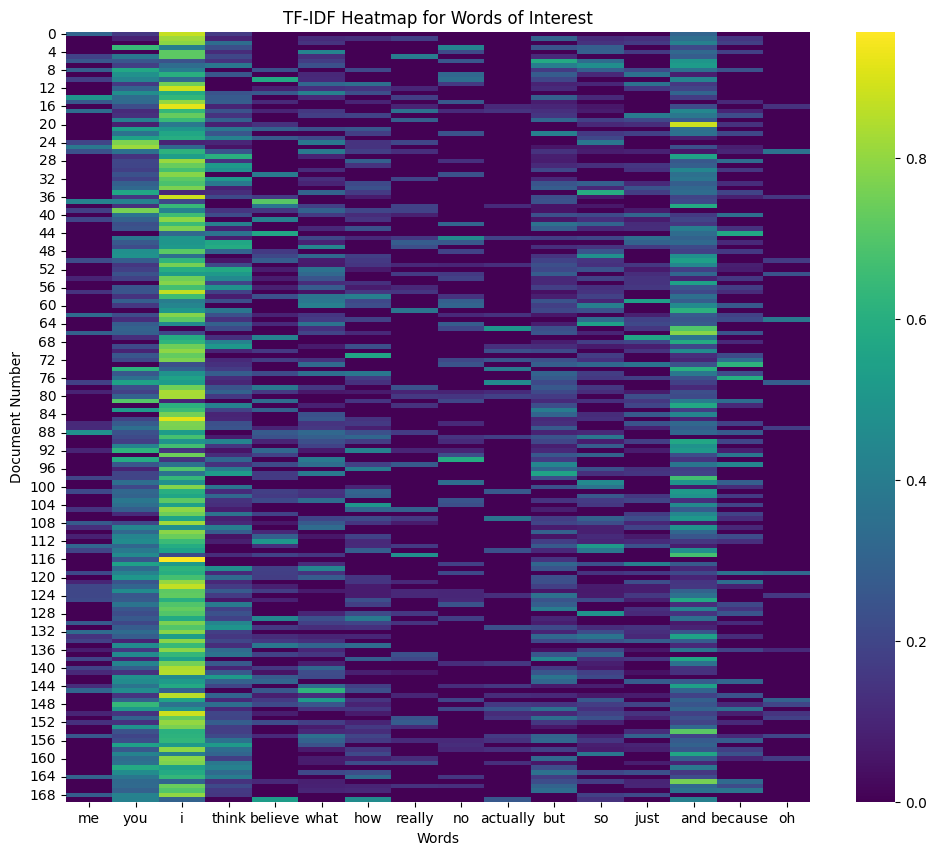

In [263]:
# Convert the TF-IDF matrix to a DataFrame for easier handling and visualization
tfidf_df = pd.DataFrame(tfidf_values, columns=words_of_interest)

# Create the heatmap using seaborn
plt.figure(figsize=(12, 10))  # You may adjust the figure size as needed
sns.heatmap(tfidf_df, cmap='viridis', annot=False)
plt.title('TF-IDF Heatmap for Words of Interest')
plt.xlabel('Words')
plt.ylabel('Document Number')
plt.show()


## CLEAN

In [274]:
# Words to compute TF-IDF for
words_of_interest = ['me', 'you', 'i', 'think', 'believe', 'what', 'how', 'really', 'no', 'actually', 'but', 'so', 'just', 'and', 'because', 'oh']

# Initialize TfidfVectorizer
vectorizer = TfidfVectorizer(vocabulary=words_of_interest)

# Fit the vectorizer and transform the documents in the specified column
tfidf_matrix = vectorizer.fit_transform(TURNS['CLEAN'])

# Get the TF-IDF values for the specified words in each document
tfidf_values = tfidf_matrix.toarray()

# Print the TF-IDF values for each word in each document
for i, doc in enumerate(TURNS['CLEAN']):
    print(f"Document {i+1}: {doc}")
    for j, word in enumerate(words_of_interest):
        tfidf_value = tfidf_values[i][j]
        print(f"   {word} : {tfidf_value:.4f}")


Streaming output truncated to the last 5000 lines.
   because : 0.0000
   oh : 0.0000
Document 2388: hello 
   me : 0.0000
   you : 0.0000
   i : 0.0000
   think : 0.0000
   believe : 0.0000
   what : 0.0000
   how : 0.0000
   really : 0.0000
   no : 0.0000
   actually : 0.0000
   but : 0.0000
   so : 0.0000
   just : 0.0000
   and : 0.0000
   because : 0.0000
   oh : 0.0000
Document 2389: hows your day so far
   me : 0.0000
   you : 0.0000
   i : 0.0000
   think : 0.0000
   believe : 0.0000
   what : 0.0000
   how : 0.0000
   really : 0.0000
   no : 0.0000
   actually : 0.0000
   but : 0.0000
   so : 1.0000
   just : 0.0000
   and : 0.0000
   because : 0.0000
   oh : 0.0000
Document 2390: not too bad and yours
   me : 0.0000
   you : 0.0000
   i : 0.0000
   think : 0.0000
   believe : 0.0000
   what : 0.0000
   how : 0.0000
   really : 0.0000
   no : 0.0000
   actually : 0.0000
   but : 0.0000
   so : 0.0000
   just : 0.0000
   and : 1.0000
   because : 0.0000
   oh : 0.0000
Document 

In [275]:
# Words to compute TF-IDF for
words_of_interest = ['me', 'you', 'i', 'think', 'believe', 'what', 'how', 'really', 'no', 'actually', 'but', 'so', 'just', 'and', 'because', 'oh']

# Initialize TfidfVectorizer to include single-letter words
vectorizer = TfidfVectorizer(vocabulary=words_of_interest, lowercase=False, token_pattern=r'(?u)\b\w+\b')

# Filter DataFrame for 'dialogue' and 'debate' conditions
dialogue_df = TURNS[TURNS['condition'] == 'dialogue']['CLEAN']
debate_df = TURNS[TURNS['condition'] == 'debate']['CLEAN']

# Vectorize and compute TF-IDF for both conditions
dialogue_tfidf = vectorizer.fit_transform(dialogue_df)
debate_tfidf = vectorizer.fit_transform(debate_df)

# Compute average TF-IDF values for each word in both conditions
dialogue_avg_tfidf = dialogue_tfidf.toarray().mean(axis=0)
debate_avg_tfidf = debate_tfidf.toarray().mean(axis=0)

# Print average TF-IDF values for 'dialogue'
print("Average TF-IDF values for 'dialogue':")
for word, avg_value in zip(words_of_interest, dialogue_avg_tfidf):
    print(f"   {word}: {avg_value:.4f}")

# Print average TF-IDF values for 'debate'
print("\nAverage TF-IDF values for 'debate':")
for word, avg_value in zip(words_of_interest, debate_avg_tfidf):
    print(f"   {word}: {avg_value:.4f}")


Average TF-IDF values for 'dialogue':
   me: 0.0269
   you: 0.1552
   i: 0.2675
   think: 0.0987
   believe: 0.0295
   what: 0.0559
   how: 0.0476
   really: 0.0176
   no: 0.0116
   actually: 0.0100
   but: 0.0803
   so: 0.0545
   just: 0.0307
   and: 0.1244
   because: 0.0282
   oh: 0.0082

Average TF-IDF values for 'debate':
   me: 0.0163
   you: 0.1132
   i: 0.2057
   think: 0.0759
   believe: 0.0329
   what: 0.0535
   how: 0.0482
   really: 0.0128
   no: 0.0227
   actually: 0.0169
   but: 0.0740
   so: 0.0497
   just: 0.0338
   and: 0.1510
   because: 0.0340
   oh: 0.0037


In [276]:
# Filter documents by condition
dialogue_docs = TURNS[TURNS['condition'] == 'dialogue']['CLEAN']
debate_docs = TURNS[TURNS['condition'] == 'debate']['CLEAN']

# Transform documents
tfidf_dialogue = vectorizer.transform(dialogue_docs).toarray()
tfidf_debate = vectorizer.transform(debate_docs).toarray()

# Calculate mean TF-IDF values for each word of interest
mean_tfidf_dialogue = tfidf_dialogue.mean(axis=0)
mean_tfidf_debate = tfidf_debate.mean(axis=0)

# Print mean TF-IDF values for dialogue and debate conditions
print("Mean TF-IDF values for 'CLEAN':")
for i, word in enumerate(words_of_interest):
    print(f"{word} - Dialogue mean TF-IDF: {mean_tfidf_dialogue[i]:.4f}, Debate mean TF-IDF: {mean_tfidf_debate[i]:.4f}")


Mean TF-IDF values for 'CLEAN':
me - Dialogue mean TF-IDF: 0.0276, Debate mean TF-IDF: 0.0163
you - Dialogue mean TF-IDF: 0.1609, Debate mean TF-IDF: 0.1132
i - Dialogue mean TF-IDF: 0.2790, Debate mean TF-IDF: 0.2057
think - Dialogue mean TF-IDF: 0.0999, Debate mean TF-IDF: 0.0759
believe - Dialogue mean TF-IDF: 0.0284, Debate mean TF-IDF: 0.0329
what - Dialogue mean TF-IDF: 0.0545, Debate mean TF-IDF: 0.0535
how - Dialogue mean TF-IDF: 0.0458, Debate mean TF-IDF: 0.0482
really - Dialogue mean TF-IDF: 0.0177, Debate mean TF-IDF: 0.0128
no - Dialogue mean TF-IDF: 0.0107, Debate mean TF-IDF: 0.0227
actually - Dialogue mean TF-IDF: 0.0095, Debate mean TF-IDF: 0.0169
but - Dialogue mean TF-IDF: 0.0797, Debate mean TF-IDF: 0.0740
so - Dialogue mean TF-IDF: 0.0538, Debate mean TF-IDF: 0.0497
just - Dialogue mean TF-IDF: 0.0297, Debate mean TF-IDF: 0.0338
and - Dialogue mean TF-IDF: 0.1176, Debate mean TF-IDF: 0.1510
because - Dialogue mean TF-IDF: 0.0269, Debate mean TF-IDF: 0.0340
oh - Dia

In [229]:
# Assuming tfidf_values is your TF-IDF matrix and words_of_interest are your terms
documents = [f"Document {i+1}" for i in range(tfidf_values.shape[0])]
tfidf_df = pd.DataFrame(tfidf_values, columns=words_of_interest)
tfidf_df['document'] = documents
tfidf_df = tfidf_df.melt(id_vars=["document"], var_name="term", value_name="tfidf")

# Adding a little randomness to break ties in term ranking
tfidf_df['tfidf'] = tfidf_df['tfidf'] + np.random.rand(tfidf_df.shape[0]) * 0.0001


In [230]:
# Base for all visualizations, with rank calculation
base = alt.Chart(tfidf_df).encode(
    x='rank:O',
    y='document:N'
).transform_window(
    rank="rank()",
    sort=[alt.SortField("tfidf", order="descending")],
    groupby=["document"],
)

# Heatmap specification
heatmap = base.mark_rect().encode(
    color='tfidf:Q'
)

# Terms in this list will get a red dot in the visualization
term_list = ['me', 'you', 'I', 'think']  # Adjust as needed

# Red circle over terms in the above list
circle = base.mark_circle(size=100).encode(
    color=alt.condition(
        alt.FieldOneOfPredicate(field='term', oneOf=term_list),
        alt.value('red'),
        alt.value('#FFFFFF00')
    )
)

# Text labels, white for darker heatmap colors
text = base.mark_text(baseline='middle').encode(
    text='term:N',
    color=alt.condition(alt.datum.tfidf >= 0.23, alt.value('white'), alt.value('black'))
)

# Display the three superimposed visualizations
(heatmap + circle + text).properties(width=600)


MaxRowsError: The number of rows in your dataset is greater than the maximum allowed (5000). For information on how to plot larger datasets in Altair, see the documentation

alt.LayerChart(...)

In [ ]:
import altair as alt
import numpy as np

# adding a little randomness to break ties in term ranking
top_tfidf_plusRand = top_tfidf.copy()
top_tfidf_plusRand['tfidf'] = top_tfidf_plusRand['tfidf'] + np.random.rand(top_tfidf.shape[0])*0.0001

# base for all visualizations, with rank calculation
base = alt.Chart(top_tfidf_plusRand).encode(
    x = 'rank:O',
    y = 'document:N'
).transform_window(
    rank = "rank()",
    sort = [alt.SortField("tfidf", order="descending")],
    groupby = ["document"],
)

# heatmap specification
heatmap = base.mark_rect().encode(
    color = 'tfidf:Q'
)

# terms in this list will get a red dot in the visualization
term_list = ['nation','national','republic','union']

# red circle over terms in above list
circle = base.mark_circle(size=100).encode(
    color = alt.condition(
        alt.FieldOneOfPredicate(field='term', oneOf=term_list),
        alt.value('red'),
        alt.value('#FFFFFF00')
    )
)

# text labels, white for darker heatmap colors
text = base.mark_text(baseline='middle').encode(
    text = 'term:N',
    color = alt.condition(alt.datum.tfidf >= 0.23, alt.value('white'), alt.value('black'))
)

# display the three superimposed visualizations
(heatmap + circle + text).properties(width = 600)

## BOTH

In [272]:
# Words to compute TF-IDF for
words_of_interest = ['me', 'you', 'i', 'think', 'believe', 'what', 'how', 'really', 'no', 'actually', 'but', 'so', 'just', 'and', 'because', 'oh']

# Initialize TfidfVectorizer
vectorizer = TfidfVectorizer(vocabulary=words_of_interest)

# Fit the vectorizer and transform the documents in the specified column
tfidf_matrix = vectorizer.fit_transform(TURNS['BOTH'])

# Get the TF-IDF values for the specified words in each document
tfidf_values = tfidf_matrix.toarray()

# Print the TF-IDF values for each word in each document
for i, doc in enumerate(TURNS['BOTH']):
    print(f"Document {i+1}: {doc}")
    for j, word in enumerate(words_of_interest):
        tfidf_value = tfidf_values[i][j]
        print(f"   {word} : {tfidf_value:.4f}")


Streaming output truncated to the last 5000 lines.
   because : 0.0000
   oh : 0.0000
Document 2388: Hello
   me : 0.0000
   you : 0.0000
   i : 0.0000
   think : 0.0000
   believe : 0.0000
   what : 0.0000
   how : 0.0000
   really : 0.0000
   no : 0.0000
   actually : 0.0000
   but : 0.0000
   so : 0.0000
   just : 0.0000
   and : 0.0000
   because : 0.0000
   oh : 0.0000
Document 2389: Hows your day so far
   me : 0.0000
   you : 0.0000
   i : 0.0000
   think : 0.0000
   believe : 0.0000
   what : 0.0000
   how : 0.0000
   really : 0.0000
   no : 0.0000
   actually : 0.0000
   but : 0.0000
   so : 1.0000
   just : 0.0000
   and : 0.0000
   because : 0.0000
   oh : 0.0000
Document 2390: Not too bad yours
   me : 0.0000
   you : 0.0000
   i : 0.0000
   think : 0.0000
   believe : 0.0000
   what : 0.0000
   how : 0.0000
   really : 0.0000
   no : 0.0000
   actually : 0.0000
   but : 0.0000
   so : 0.0000
   just : 0.0000
   and : 0.0000
   because : 0.0000
   oh : 0.0000
Document 2391:

In [236]:
# Words to compute TF-IDF for
words_of_interest = ['me', 'you', 'i', 'think', 'believe', 'what', 'how', 'really', 'no', 'actually', 'but', 'so', 'just', 'and', 'because', 'oh']

# Initialize TfidfVectorizer to include single-letter words
vectorizer = TfidfVectorizer(vocabulary=words_of_interest, lowercase=False, token_pattern=r'(?u)\b\w+\b')

# Filter DataFrame for 'dialogue' and 'debate' conditions
dialogue_df = TURNS[TURNS['condition'] == 'dialogue']['BOTH']
debate_df = TURNS[TURNS['condition'] == 'debate']['BOTH']

# Vectorize and compute TF-IDF for both conditions
dialogue_tfidf = vectorizer.fit_transform(dialogue_df)
debate_tfidf = vectorizer.fit_transform(debate_df)

# Compute average TF-IDF values for each word in both conditions
dialogue_avg_tfidf = dialogue_tfidf.toarray().mean(axis=0)
debate_avg_tfidf = debate_tfidf.toarray().mean(axis=0)

# Print average TF-IDF values for 'dialogue'
print("Average TF-IDF values for 'dialogue':")
for word, avg_value in zip(words_of_interest, dialogue_avg_tfidf):
    print(f"   {word}: {avg_value:.4f}")

# Print average TF-IDF values for 'debate'
print("\nAverage TF-IDF values for 'debate':")
for word, avg_value in zip(words_of_interest, debate_avg_tfidf):
    print(f"   {word}: {avg_value:.4f}")


Average TF-IDF values for 'dialogue':
   me: 0.0287
   you: 0.1807
   i: 0.0227
   think: 0.1280
   believe: 0.0344
   what: 0.0396
   how: 0.0287
   really: 0.0177
   no: 0.0118
   actually: 0.0115
   but: 0.0723
   so: 0.0373
   just: 0.0331
   and: 0.0000
   because: 0.0328
   oh: 0.0010

Average TF-IDF values for 'debate':
   me: 0.0180
   you: 0.1251
   i: 0.0236
   think: 0.0946
   believe: 0.0371
   what: 0.0410
   how: 0.0367
   really: 0.0131
   no: 0.0178
   actually: 0.0175
   but: 0.0688
   so: 0.0397
   just: 0.0349
   and: 0.0000
   because: 0.0360
   oh: 0.0000


In [237]:
# Filter documents by condition
dialogue_docs = TURNS[TURNS['condition'] == 'dialogue']['BOTH']
debate_docs = TURNS[TURNS['condition'] == 'debate']['BOTH']

# Transform documents
tfidf_dialogue = vectorizer.transform(dialogue_docs).toarray()
tfidf_debate = vectorizer.transform(debate_docs).toarray()

# Calculate mean TF-IDF values for each word of interest
mean_tfidf_dialogue = tfidf_dialogue.mean(axis=0)
mean_tfidf_debate = tfidf_debate.mean(axis=0)

# Print mean TF-IDF values for dialogue and debate conditions
print("Mean TF-IDF values for 'BOTH':")
for i, word in enumerate(words_of_interest):
    print(f"{word} - Dialogue mean TF-IDF: {mean_tfidf_dialogue[i]:.4f}, Debate mean TF-IDF: {mean_tfidf_debate[i]:.4f}")


Mean TF-IDF values for 'BOTH':
me - Dialogue mean TF-IDF: 0.0294, Debate mean TF-IDF: 0.0180
you - Dialogue mean TF-IDF: 0.1852, Debate mean TF-IDF: 0.1251
i - Dialogue mean TF-IDF: 0.0223, Debate mean TF-IDF: 0.0236
think - Dialogue mean TF-IDF: 0.1305, Debate mean TF-IDF: 0.0946
believe - Dialogue mean TF-IDF: 0.0339, Debate mean TF-IDF: 0.0371
what - Dialogue mean TF-IDF: 0.0387, Debate mean TF-IDF: 0.0410
how - Dialogue mean TF-IDF: 0.0274, Debate mean TF-IDF: 0.0367
really - Dialogue mean TF-IDF: 0.0178, Debate mean TF-IDF: 0.0131
no - Dialogue mean TF-IDF: 0.0113, Debate mean TF-IDF: 0.0178
actually - Dialogue mean TF-IDF: 0.0112, Debate mean TF-IDF: 0.0175
but - Dialogue mean TF-IDF: 0.0721, Debate mean TF-IDF: 0.0688
so - Dialogue mean TF-IDF: 0.0368, Debate mean TF-IDF: 0.0397
just - Dialogue mean TF-IDF: 0.0326, Debate mean TF-IDF: 0.0349
and - Dialogue mean TF-IDF: 0.0000, Debate mean TF-IDF: 0.0000
because - Dialogue mean TF-IDF: 0.0322, Debate mean TF-IDF: 0.0360
oh - Dial

In [ ]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

num_clusters = 10
num_seeds = 10
max_iterations = 300
labels_color_map = {
    0: '#20b2aa', 1: '#ff7373', 2: '#ffe4e1', 3: '#005073', 4: '#4d0404',
    5: '#ccc0ba', 6: '#4700f9', 7: '#f6f900', 8: '#00f91d', 9: '#da8c49'
}
pca_num_components = 2
tsne_num_components = 2

# texts_list = some array of strings for which TF-IDF is being computed

# calculate tf-idf of texts
tf_idf_vectorizer = TfidfVectorizer(analyzer="word", use_idf=True, smooth_idf=True, ngram_range=(2, 3))
tf_idf_matrix = tf_idf_vectorizer.fit_transform(texts_list)

# create k-means model with custom config
clustering_model = KMeans(
    n_clusters=num_clusters,
    max_iter=max_iterations,
    precompute_distances="auto",
    n_jobs=-1
)

labels = clustering_model.fit_predict(tf_idf_matrix)
# print labels

X = tf_idf_matrix.todense()

# ----------------------------------------------------------------------------------------------------------------------

reduced_data = PCA(n_components=pca_num_components).fit_transform(X)
# print reduced_data

fig, ax = plt.subplots()
for index, instance in enumerate(reduced_data):
    # print instance, index, labels[index]
    pca_comp_1, pca_comp_2 = reduced_data[index]
    color = labels_color_map[labels[index]]
    ax.scatter(pca_comp_1, pca_comp_2, c=color)
plt.show()



# t-SNE plot
embeddings = TSNE(n_components=tsne_num_components)
Y = embeddings.fit_transform(X)
plt.scatter(Y[:, 0], Y[:, 1], cmap=plt.cm.Spectral)
plt.show()

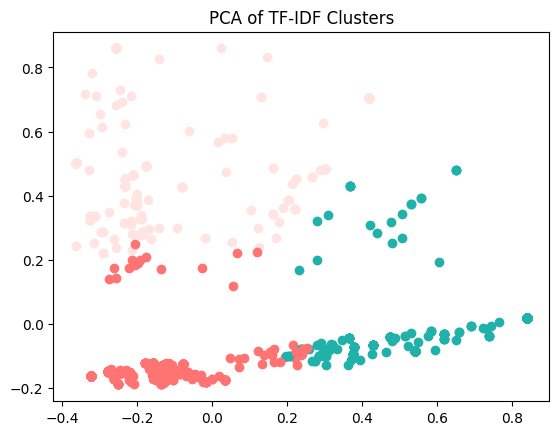

<ipython-input-273-5411960a0d6e>:48: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(Y_tsne[:, 0], Y_tsne[:, 1], c=[labels_color_map[label] for label in labels], cmap=plt.cm.Spectral)


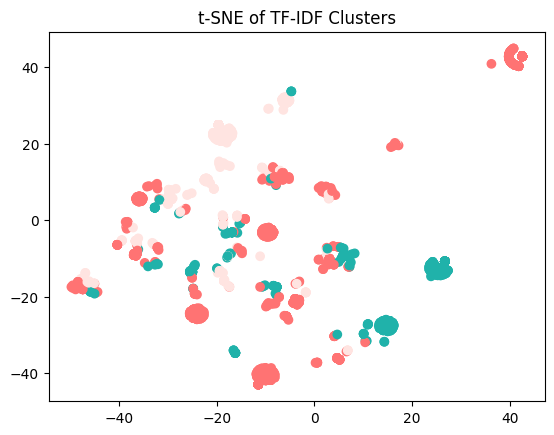

In [273]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

num_clusters = 3
max_iterations = 300
n_init = 10  # Explicitly specifying n_init to suppress the FutureWarning
labels_color_map = {
    0: '#20b2aa', 1: '#ff7373', 2: '#ffe4e1', 3: '#005073', 4: '#4d0404',
    5: '#ccc0ba', 6: '#4700f9', 7: '#f6f900', 8: '#00f91d', 9: '#da8c49'
}
pca_num_components = 2
tsne_num_components = 2

# Initialize the KMeans clustering model with specified n_init
clustering_model = KMeans(
    n_clusters=num_clusters,
    max_iter=max_iterations,
    n_init=n_init
)

# Fit the clustering model and predict the cluster labels for each document
labels = clustering_model.fit_predict(tfidf_matrix)

# Convert the TF-IDF sparse matrix to a dense NumPy array
X_dense = np.asarray(tfidf_matrix.todense())

# PCA for dimensionality reduction for visualization
pca_reduced_data = PCA(n_components=pca_num_components).fit_transform(X_dense)

# Visualization using PCA-reduced data
fig, ax = plt.subplots()
for index, instance in enumerate(pca_reduced_data):
    pca_comp_1, pca_comp_2 = pca_reduced_data[index]
    color = labels_color_map[labels[index]]
    ax.scatter(pca_comp_1, pca_comp_2, c=color)
plt.title('PCA of TF-IDF Clusters')
plt.show()

# t-SNE for dimensionality reduction to visualize the clusters in a two-dimensional space
tsne_embeddings = TSNE(n_components=tsne_num_components)
Y_tsne = tsne_embeddings.fit_transform(X_dense)

# Visualization using t-SNE-reduced data
plt.scatter(Y_tsne[:, 0], Y_tsne[:, 1], c=[labels_color_map[label] for label in labels], cmap=plt.cm.Spectral)
plt.title('t-SNE of TF-IDF Clusters')
plt.show()


#SENTIMENT ANALYSIS

## HuggingFace

In [279]:
# Load the sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [304]:
def predict_sentiment(text, pipeline):
    result = pipeline(text)
    return result[0]

# Apply the sentiment prediction on the 'document' column
# Ensure we are saving the results in a column named 'sentiment_result'
TURNS['HF_SENT'] = TURNS['BOTH'].apply(lambda x: predict_sentiment(x, sentiment_pipeline))


In [305]:
# Extract label and score from the result
TURNS['HF_LABEL'] = TURNS['HF_SENT'].apply(lambda x: x['label'])
TURNS['HF_SCORE'] = TURNS['HF_SENT'].apply(lambda x: x['score'])


In [306]:
# Convert sentiments to numeric values
TURNS['HF_NUM'] = TURNS['HF_LABEL'].apply(lambda x: 1 if x == 'POSITIVE' else -1)

# Group by 'condition' and calculate the average sentiment
average_sentiment_scores = TURNS.groupby('condition')['HF_NUM'].mean()


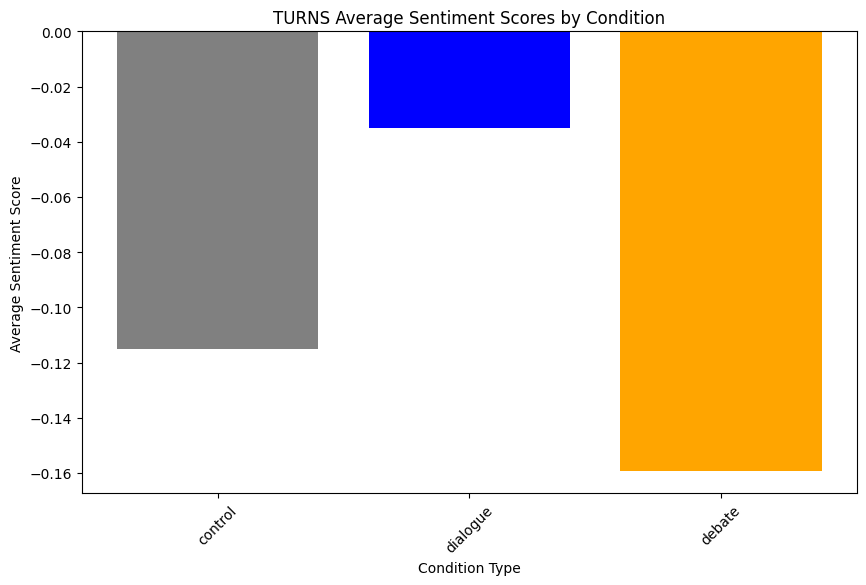

In [307]:
# Defining the order and color mapping
new_order = ['control', 'dialogue', 'debate']
color_map = {'control': 'gray', 'dialogue': 'blue', 'debate': 'orange'}

# Reorder 'document_types' and 'scores' according to 'new_order'
reordered_scores = [average_sentiment_scores.loc[doctype] for doctype in new_order]
reordered_colors = [color_map[doctype] for doctype in new_order]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(new_order, reordered_scores, color=reordered_colors)
plt.xlabel('Condition Type')
plt.ylabel('Average Sentiment Score')
plt.title('TURNS Average Sentiment Scores by Condition')
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.show()


In [310]:
def predict_sentiment(text, pipeline):
    result = pipeline(text)
    return result[0]

# Apply the sentiment prediction on the 'document' column
# Ensure we are saving the results in a column named 'sentiment_result'
FULLCONVO['HF_SENT'] = FULLCONVO['BOTH'].apply(lambda x: predict_sentiment(x, sentiment_pipeline))


In [291]:
# Extract label and score from the result
FULLCONVO['HF_LABEL'] = FULLCONVO['HF_SENT'].apply(lambda x: x['label'])
FULLCONVO['HF_SCORE'] = FULLCONVO['HF_SENT'].apply(lambda x: x['score'])


In [292]:
# Convert sentiments to numeric values
FULLCONVO['HF_NUM'] = FULLCONVO['HF_LABEL'].apply(lambda x: 1 if x == 'POSITIVE' else -1)

# Group by 'condition' and calculate the average sentiment
average_sentiment_scores = FULLCONVO.groupby('condition')['HF_NUM'].mean()


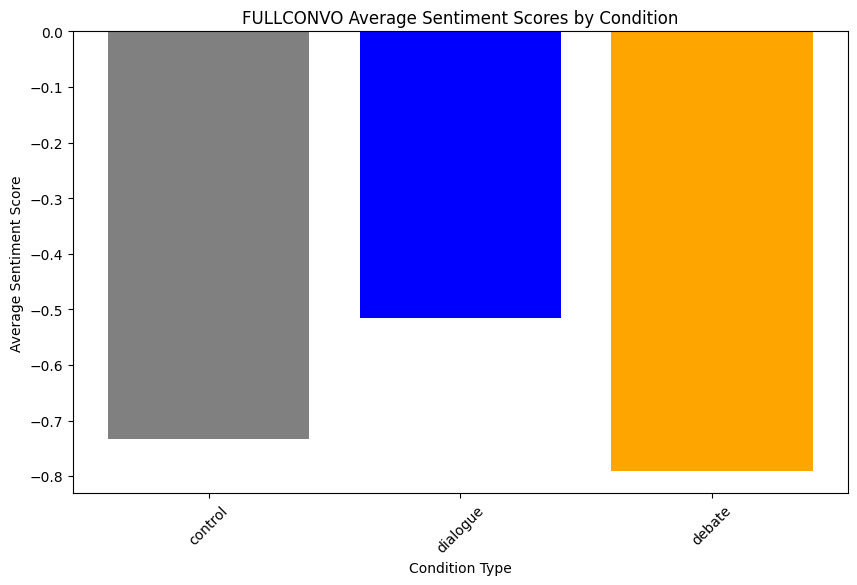

In [294]:
# Defining the order and color mapping
new_order = ['control', 'dialogue', 'debate']
color_map = {'control': 'gray', 'dialogue': 'blue', 'debate': 'orange'}

# Reorder 'document_types' and 'scores' according to 'new_order'
reordered_scores = [average_sentiment_scores.loc[doctype] for doctype in new_order]
reordered_colors = [color_map[doctype] for doctype in new_order]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(new_order, reordered_scores, color=reordered_colors)
plt.xlabel('Condition Type')
plt.ylabel('Average Sentiment Score')
plt.title('FULLCONVO Average Sentiment Scores by Condition')
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.show()


## VADER

In [295]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [297]:
# Initialize the VADER sentiment intensity analyzer
sia = SentimentIntensityAnalyzer()

# Example function to analyze sentiment of a text
def analyze_sentiment_vader(text):
    score = sia.polarity_scores(text)
    return score['compound']  # Compound score represents the overall sentiment

# Apply the function to each document in your DataFrame
TURNS['VADER'] = TURNS['BOTH'].apply(analyze_sentiment_vader)

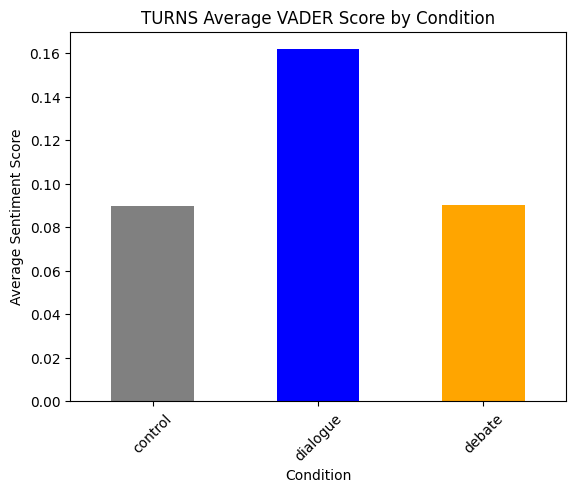

In [300]:
# Calculate average sentiment score for each condition
avg_sentiment_scores = TURNS.groupby('condition')['VADER'].mean()

# Reordering and recoloring
new_order = ['control', 'dialogue', 'debate']
colors = ['gray', 'blue', 'orange']

# Reorder 'avg_sentiment_scores' according to 'new_order'
reordered_scores = avg_sentiment_scores.reindex(new_order)

# Plotting with the specified order and colors
reordered_scores.plot(kind='bar', color=colors)
plt.title('TURNS Average VADER Score by Condition')
plt.xlabel('Condition')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=45)
plt.show()


In [301]:
# Initialize the VADER sentiment intensity analyzer
sia = SentimentIntensityAnalyzer()

# Example function to analyze sentiment of a text
def analyze_sentiment_vader(text):
    score = sia.polarity_scores(text)
    return score['compound']  # Compound score represents the overall sentiment

# Apply the function to each document in your DataFrame
FULLCONVO['VADER'] = FULLCONVO['BOTH'].apply(analyze_sentiment_vader)

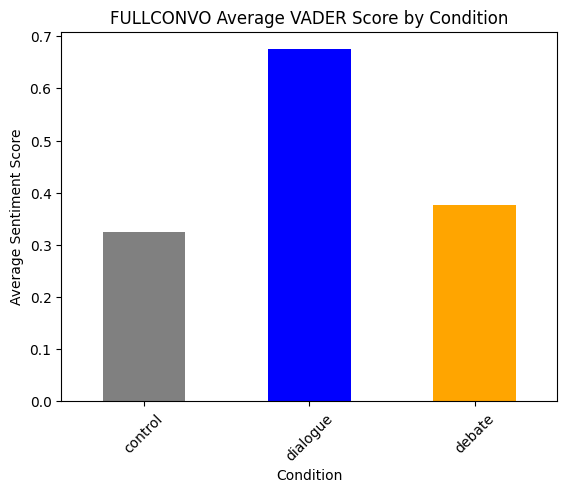

In [303]:
# Calculate average sentiment score for each condition
avg_sentiment_scores = FULLCONVO.groupby('condition')['VADER'].mean()

# Reordering and recoloring
new_order = ['control', 'dialogue', 'debate']
colors = ['gray', 'blue', 'orange']

# Reorder 'avg_sentiment_scores' according to 'new_order'
reordered_scores = avg_sentiment_scores.reindex(new_order)

# Plotting with the specified order and colors
reordered_scores.plot(kind='bar', color=colors)
plt.title('FULLCONVO Average VADER Score by Condition')
plt.xlabel('Condition')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=45)
plt.show()


## NRC

In [316]:
# Function to analyze text with NRC Emotion Lexicon
def analyze_emotion_nrc(text):
    text_object = NRCLex(text)
    return text_object.affect_frequencies  # Returns the frequency of each emotion in the text

# Apply the function to each document in your DataFrame
TURNS['NRC'] = TURNS['BOTH'].apply(analyze_emotion_nrc)


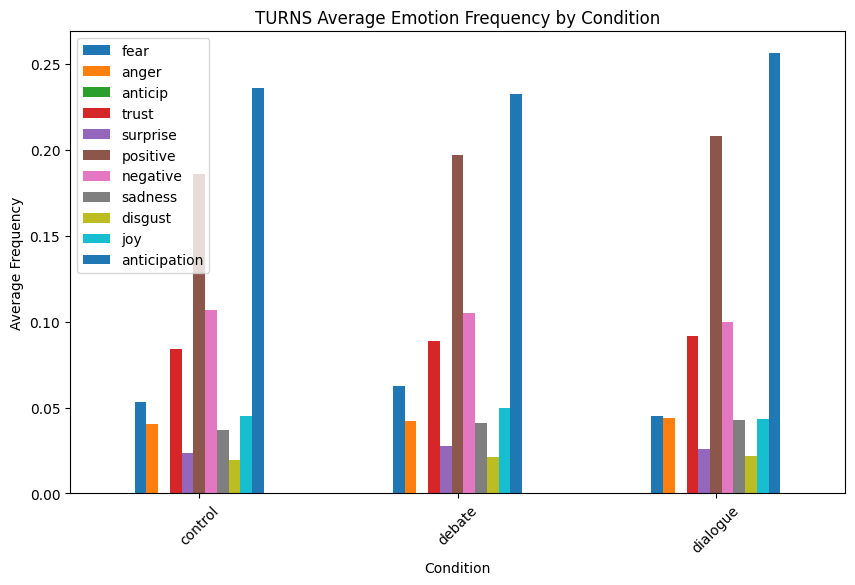

In [318]:
# Convert emotion frequencies to DataFrame
emotion_df = TURNS['NRC'].apply(pd.Series)

# Add 'condition' column to emotion_df
emotion_df['condition'] = TURNS['condition']

# Calculate average emotion frequency for each condition
avg_emotion_freqs = emotion_df.groupby('condition').mean()

# Plot
avg_emotion_freqs.plot(kind='bar', stacked=False, figsize=(10, 6))
plt.title('TURNS Average Emotion Frequency by Condition')
plt.xlabel('Condition')
plt.ylabel('Average Frequency')
plt.xticks(rotation=45)
plt.show()


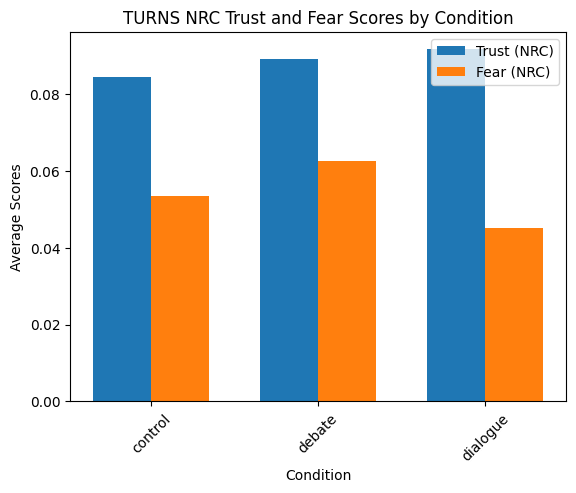

In [321]:
# For NRC, calculating the average presence of 'trust' and 'fear'
nrc_trust = TURNS['NRC'].apply(lambda x: x.get('trust', 0))
nrc_fear = TURNS['NRC'].apply(lambda x: x.get('fear', 0))

# Add calculated trust and fear scores back to the DataFrame
TURNS['trust'] = nrc_trust
TURNS['fear'] = nrc_fear

# Calculate averages for trust and fear across conditions
nrc_trust_averages = TURNS.groupby('condition')['trust'].mean()
nrc_fear_averages = TURNS.groupby('condition')['fear'].mean()

# Creating a grouped bar chart
categories = nrc_trust_averages.index
x = np.arange(len(categories))  # Create an array with the number of categories
width = 0.35  # Width of the bars

fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, nrc_trust_averages, width, label='Trust (NRC)')
bars2 = ax.bar(x + width/2, nrc_fear_averages, width, label='Fear (NRC)')

ax.set_xlabel('Condition')
ax.set_ylabel('Average Scores')
ax.set_title('TURNS NRC Trust and Fear Scores by Condition')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

plt.xticks(rotation=45)  # Rotate category labels if needed
plt.show()


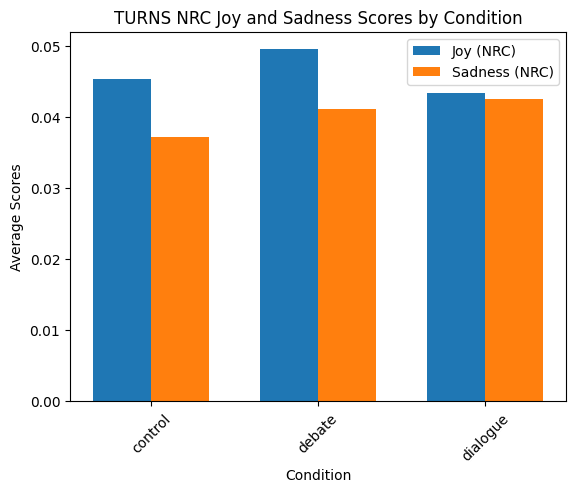

In [324]:
# For NRC, calculating the average presence of 'joy' and 'sadness'
nrc_joy = TURNS['NRC'].apply(lambda x: x.get('joy', 0))
nrc_sadness = TURNS['NRC'].apply(lambda x: x.get('sadness', 0))

# Add calculated trust and fear scores back to the DataFrame
TURNS['joy'] = nrc_joy
TURNS['sadness'] = nrc_sadness

# Calculate averages for trust and fear across conditions
nrc_trust_averages = TURNS.groupby('condition')['joy'].mean()
nrc_fear_averages = TURNS.groupby('condition')['sadness'].mean()

# Creating a grouped bar chart
categories = nrc_trust_averages.index
x = np.arange(len(categories))  # Create an array with the number of categories
width = 0.35  # Width of the bars

fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, nrc_trust_averages, width, label='Joy (NRC)')
bars2 = ax.bar(x + width/2, nrc_fear_averages, width, label='Sadness (NRC)')

ax.set_xlabel('Condition')
ax.set_ylabel('Average Scores')
ax.set_title('TURNS NRC Joy and Sadness Scores by Condition')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

plt.xticks(rotation=45)  # Rotate category labels if needed
plt.show()

In [319]:
# Apply the function to each document in your DataFrame
FULLCONVO['NRC'] = FULLCONVO['BOTH'].apply(analyze_emotion_nrc)


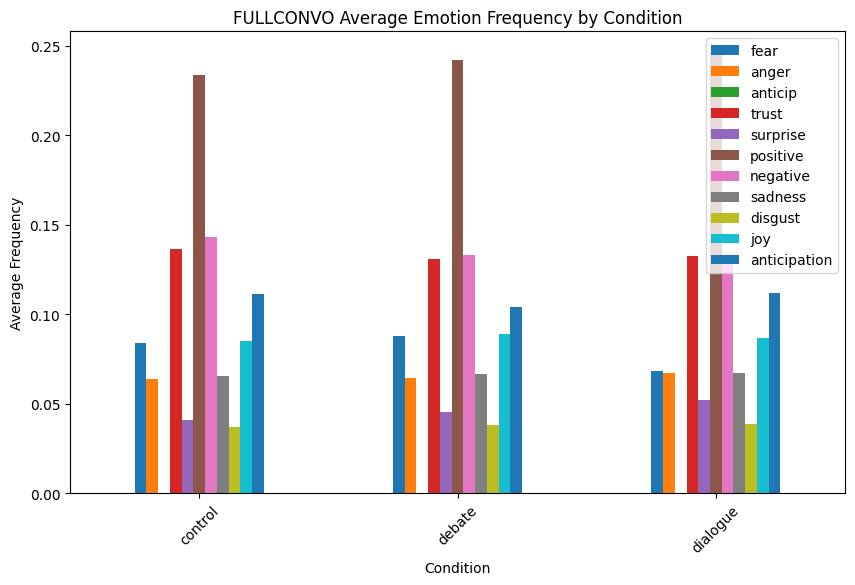

In [320]:
# Convert emotion frequencies to DataFrame
emotion_df = FULLCONVO['NRC'].apply(pd.Series)

# Add 'condition' column to emotion_df
emotion_df['condition'] = FULLCONVO['condition']

# Calculate average emotion frequency for each condition
avg_emotion_freqs = emotion_df.groupby('condition').mean()

# Plot
avg_emotion_freqs.plot(kind='bar', stacked=False, figsize=(10, 6))
plt.title('FULLCONVO Average Emotion Frequency by Condition')
plt.xlabel('Condition')
plt.ylabel('Average Frequency')
plt.xticks(rotation=45)
plt.show()


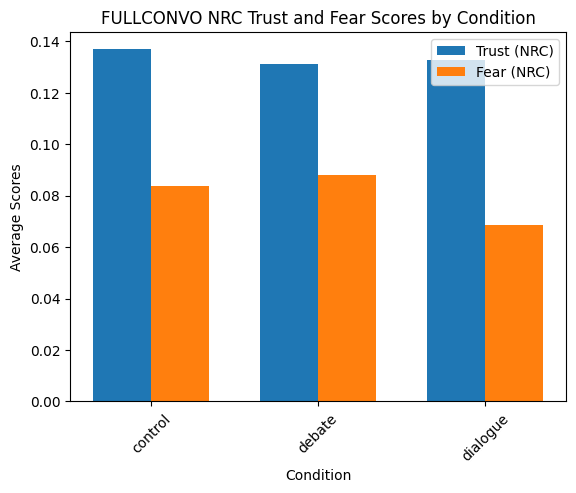

In [322]:
# For NRC, calculating the average presence of 'trust' and 'fear'
nrc_trust = FULLCONVO['NRC'].apply(lambda x: x.get('trust', 0))
nrc_fear = FULLCONVO['NRC'].apply(lambda x: x.get('fear', 0))

# Add calculated trust and fear scores back to the DataFrame
FULLCONVO['trust'] = nrc_trust
FULLCONVO['fear'] = nrc_fear

# Calculate averages for trust and fear across conditions
nrc_trust_averages = FULLCONVO.groupby('condition')['trust'].mean()
nrc_fear_averages = FULLCONVO.groupby('condition')['fear'].mean()

# Creating a grouped bar chart
categories = nrc_trust_averages.index
x = np.arange(len(categories))  # Create an array with the number of categories
width = 0.35  # Width of the bars

fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, nrc_trust_averages, width, label='Trust (NRC)')
bars2 = ax.bar(x + width/2, nrc_fear_averages, width, label='Fear (NRC)')

ax.set_xlabel('Condition')
ax.set_ylabel('Average Scores')
ax.set_title('FULLCONVO NRC Trust and Fear Scores by Condition')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

plt.xticks(rotation=45)  # Rotate category labels if needed
plt.show()


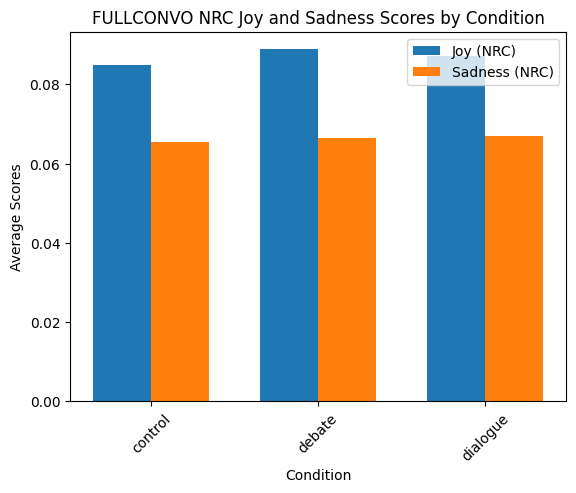

In [325]:
# For NRC, calculating the average presence of 'joy' and 'sadness'
nrc_joy = FULLCONVO['NRC'].apply(lambda x: x.get('joy', 0))
nrc_sadness = FULLCONVO['NRC'].apply(lambda x: x.get('sadness', 0))

# Add calculated trust and fear scores back to the DataFrame
FULLCONVO['joy'] = nrc_joy
FULLCONVO['sadness'] = nrc_sadness

# Calculate averages for trust and fear across conditions
nrc_trust_averages = FULLCONVO.groupby('condition')['joy'].mean()
nrc_fear_averages = FULLCONVO.groupby('condition')['sadness'].mean()

# Creating a grouped bar chart
categories = nrc_trust_averages.index
x = np.arange(len(categories))  # Create an array with the number of categories
width = 0.35  # Width of the bars

fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, nrc_trust_averages, width, label='Joy (NRC)')
bars2 = ax.bar(x + width/2, nrc_fear_averages, width, label='Sadness (NRC)')

ax.set_xlabel('Condition')
ax.set_ylabel('Average Scores')
ax.set_title('FULLCONVO NRC Joy and Sadness Scores by Condition')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

plt.xticks(rotation=45)  # Rotate category labels if needed
plt.show()

# Vectors

## Making Vectors

### LEM Vectors

In [66]:
client = OpenAI()

def get_embedding(text):
    response = client.embeddings.create(
        input=text,
        model="text-embedding-3-small"
    )
    return response.data[0].embedding

# Apply the function to each row in LEM_T and store the result in a new column
TURNS['LEM_VECTORS'] = TURNS['LEM_T'].apply(get_embedding)
TURNS.to_csv('output/LEM_VECTORS.csv', index=False)

In [68]:
# Save the DataFrame to Google Drive
output_path = '/content/drive/My Drive/Colab Notebooks/Data/LEM_VECTORS.csv'
TURNS.to_csv(output_path, index=False)


In [76]:
# Load the DataFrame from Google Drive
LEM_VECTORS = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Data/LEM_VECTORS.csv')

In [77]:
# Convert string representations of lists to actual lists
LEM_VECTORS['LEM_VECTORS'] = LEM_VECTORS['LEM_VECTORS'].apply(ast.literal_eval)

In [79]:
# Convert the column to a NumPy array
LEM_ARRAY = np.array(LEM_VECTORS['LEM_VECTORS'].tolist())

In [80]:
LEM_ARRAY

array([[ 0.01681493, -0.05572698,  0.00566734, ..., -0.01120996,
        -0.01597859, -0.01748988],
       [-0.02449618, -0.01429328,  0.01110247, ..., -0.01273248,
        -0.02014438, -0.02421939],
       [ 0.04618926,  0.01750636,  0.0378201 , ..., -0.0097596 ,
        -0.02308139,  0.00695885],
       ...,
       [ 0.0037717 ,  0.03205944,  0.06237102, ..., -0.00397006,
        -0.01995091, -0.02704584],
       [-0.01337897, -0.01026707,  0.0407726 , ...,  0.01565561,
         0.01818357, -0.01256588],
       [ 0.03220297,  0.01944985,  0.00199601, ..., -0.0046657 ,
        -0.01239294,  0.03703209]])

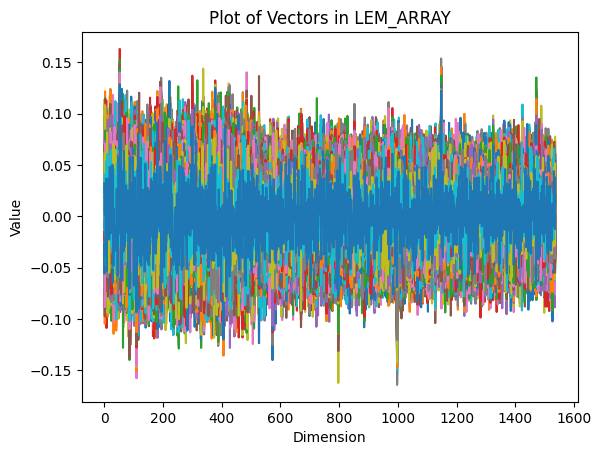

In [82]:
# Plot each vector in 'LEM_ARRAY'
for vector in LEM_ARRAY:
    plt.plot(vector)

plt.title('Plot of Vectors in LEM_ARRAY')
plt.xlabel('Dimension')
plt.ylabel('Value')
plt.show()

### STOP Vectors

In [83]:
client = OpenAI()

def get_embedding(text):
    response = client.embeddings.create(
        input=text,
        model="text-embedding-3-small"
    )
    return response.data[0].embedding

# Apply the function to each row in LEM_T and store the result in a new column
TURNS['STOP_VECTORS'] = TURNS['STOP'].apply(get_embedding)
TURNS.to_csv('output/STOP_VECTORS.csv', index=False)

In [84]:
# Save the DataFrame to Google Drive
output_path = '/content/drive/My Drive/Colab Notebooks/Data/STOP_VECTORS.csv'
TURNS.to_csv(output_path, index=False)


In [85]:
# Load the DataFrame from Google Drive
STOP_VECTORS = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Data/STOP_VECTORS.csv')

In [86]:
# Convert string representations of lists to actual lists
STOP_VECTORS['STOP_VECTORS'] = STOP_VECTORS['STOP_VECTORS'].apply(ast.literal_eval)

In [87]:
# Convert the column to a NumPy array
STOP_ARRAY = np.array(STOP_VECTORS['STOP_VECTORS'].tolist())

In [88]:
STOP_ARRAY

array([[ 0.01926439, -0.06450473, -0.00167294, ..., -0.00209983,
        -0.01471531, -0.02289048],
       [-0.02449618, -0.01429328,  0.01110247, ..., -0.01273248,
        -0.02014438, -0.02421939],
       [ 0.04566794,  0.01670747,  0.03688966, ..., -0.01038502,
        -0.02438846,  0.0053362 ],
       ...,
       [ 0.00597307,  0.02182224,  0.06772181, ..., -0.00172456,
        -0.01946308, -0.02588139],
       [-0.01017362, -0.00162518,  0.02845688, ...,  0.00665511,
         0.02021722, -0.00653728],
       [ 0.03220297,  0.01944985,  0.00199601, ..., -0.0046657 ,
        -0.01239294,  0.03703209]])

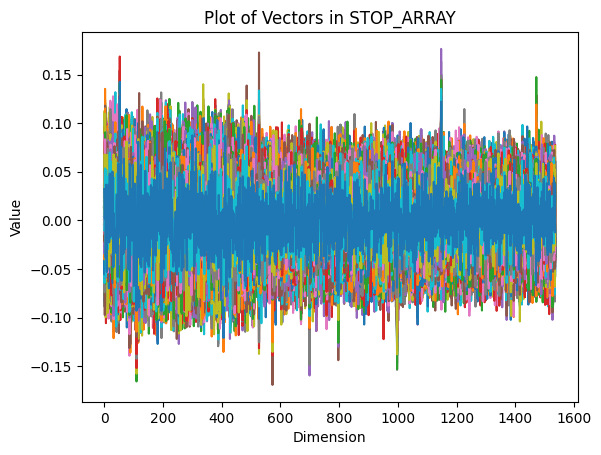

In [89]:
# Plot each vector in 'STOP_ARRAY'
for vector in STOP_ARRAY:
    plt.plot(vector)

plt.title('Plot of Vectors in STOP_ARRAY')
plt.xlabel('Dimension')
plt.ylabel('Value')
plt.show()

### BOTH Vectors

In [90]:
client = OpenAI()

def get_embedding(text):
    response = client.embeddings.create(
        input=text,
        model="text-embedding-3-small"
    )
    return response.data[0].embedding

# Apply the function to each row in BOTH and store the result in a new column
TURNS['BOTH_VECTORS'] = TURNS['BOTH'].apply(get_embedding)
TURNS.to_csv('output/BOTH_VECTORS.csv', index=False)

In [91]:
# Save the DataFrame to Google Drive
output_path = '/content/drive/My Drive/Colab Notebooks/Data/BOTH_VECTORS.csv'
TURNS.to_csv(output_path, index=False)


In [92]:
# Load the DataFrame from Google Drive
BOTH_VECTORS = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Data/BOTH_VECTORS.csv')

In [93]:
# Convert string representations of lists to actual lists
BOTH_VECTORS['BOTH_VECTORS'] = BOTH_VECTORS['BOTH_VECTORS'].apply(ast.literal_eval)

In [95]:
# Convert the column to a NumPy array
BOTH_ARRAY = np.array(BOTH_VECTORS['BOTH_VECTORS'].tolist())

In [96]:
BOTH_ARRAY

array([[ 0.01926439, -0.06450473, -0.00167294, ..., -0.00209983,
        -0.01471531, -0.02289048],
       [-0.02449618, -0.01429328,  0.01110247, ..., -0.01273248,
        -0.02014438, -0.02421939],
       [ 0.04566794,  0.01670747,  0.03688966, ..., -0.01038502,
        -0.02438846,  0.0053362 ],
       ...,
       [ 0.00816627,  0.02979367,  0.05678485, ...,  0.00226984,
        -0.02255774, -0.01929582],
       [-0.01017362, -0.00162518,  0.02845688, ...,  0.00665511,
         0.02021722, -0.00653728],
       [ 0.03220297,  0.01944985,  0.00199601, ..., -0.0046657 ,
        -0.01239294,  0.03703209]])

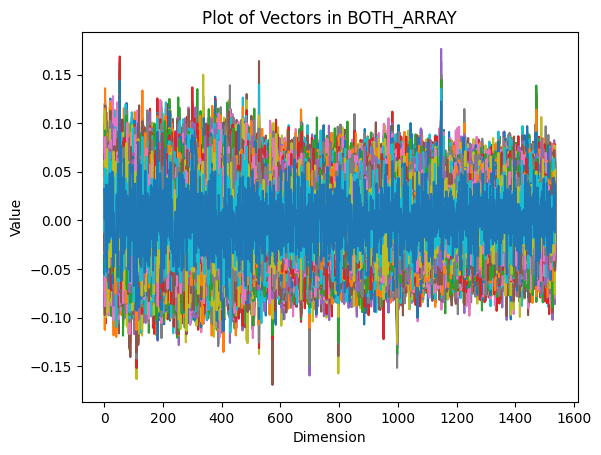

In [97]:
# Plot each vector in 'BOTH_ARRAY'
for vector in BOTH_ARRAY:
    plt.plot(vector)

plt.title('Plot of Vectors in BOTH_ARRAY')
plt.xlabel('Dimension')
plt.ylabel('Value')
plt.show()

### WINNING Vectors

In [125]:
client = OpenAI()

def get_embedding(text):
    response = client.embeddings.create(
        input=text,
        model="text-embedding-3-small"
    )
    return response.data[0].embedding

# First, create a DataFrame to store utterances and their embeddings
utterances_df = pd.DataFrame(columns=['Utterance_Text', 'Embedding'])

# Iterate through each utterance in the corpus
for utterance_id in WINNING.utterances:
    utterance = WINNING.utterances[utterance_id]
    text = utterance.text
    embedding = get_embedding(text)
    # Store the embedding in the utterance's metadata
    utterance.meta['embedding'] = embedding
    # Append to the DataFrame using pandas.concat
    new_row = pd.DataFrame({'Utterance_Text': [text], 'Embedding': [embedding]})
    utterances_df = pd.concat([utterances_df, new_row], ignore_index=True)

#Saves the updated corpus with embeddings in the metadata
WINNING.dump("path_to_save_your_updated_corpus")

# Save the DataFrame to CSV, containing utterance texts and their embeddings
utterances_df.to_csv('output/WINNING.csv', index=False)


In [126]:
corpus_dir = "/content/WINNING_corpus_with_embeddings"
WINNING.dump(corpus_dir)

In [128]:
shutil.copytree(corpus_dir, "/content/drive/My Drive/Colab Notebooks/Data/WINNING")

'/content/drive/My Drive/Colab Notebooks/Data/WINNING'

In [ ]:
#code to load from drive for new sessions
shutil.copytree("/content/drive/My Drive/REDDIT5K_corpus_with_embeddings", "/content/REDDIT5K_corpus_with_embeddings_reloaded")
WINNING = Corpus("/content/REDDIT5K_corpus_with_embeddings_reloaded")


In [370]:
import numpy as np
import pandas as pd

# Assuming 'utterances_df' is your DataFrame loaded with embeddings
# Convert list of embeddings from DataFrame to a numpy array
WIN_ARRAY = np.vstack(utterances_df['Embedding'].apply(np.array))

# Now, 'embeddings_array' is ready for comparison with 'LEM_ARRAY' or for alignment


### Topic Vectors

In [337]:
# Extract unique topics
TOPICS = TURNS['chosen_topic'].unique()

# Create a new DataFrame with unique topics
TOPICS = pd.DataFrame(TOPICS, columns=['TOPIC'])

In [338]:
#making vectors for each  chosen_topic and store the result in a new column
client = OpenAI()

def get_embedding(text):
    response = client.embeddings.create(
        input=text,
        model="text-embedding-3-small"
    )
    return response.data[0].embedding


TOPICS['TOPIC_VECTORS'] = TOPICS['TOPIC'].apply(get_embedding)
TOPICS.to_csv('output/TOPIC_VECTORS.csv', index=False)

In [339]:
# Save the DataFrame to Google Drive
output_path = '/content/drive/My Drive/Colab Notebooks/Data/TOPIC_VECTORS.csv'
TURNS.to_csv(output_path, index=False)


In [340]:
# Load the DataFrame from Google Drive
TOPIC_VECTORS = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Data/TOPIC_VECTORS.csv')

In [343]:
# Convert the column to a NumPy array
TOPIC_ARRAY = np.array(TOPICS['TOPIC_VECTORS'].tolist())

In [344]:
TOPIC_ARRAY

array([[ 0.04595646,  0.04933733,  0.0140714 , ..., -0.01577349,
        -0.03380866,  0.01387321],
       [ 0.04733337,  0.03636751,  0.01380186, ..., -0.01642655,
        -0.01086577,  0.00383416],
       [ 0.00107422,  0.01603759,  0.0325932 , ...,  0.00844357,
        -0.03893364, -0.02602483],
       ...,
       [ 0.05874464, -0.02011446, -0.00943136, ..., -0.00382026,
        -0.00063013,  0.03566816],
       [ 0.03014608,  0.00301284, -0.02041092, ..., -0.02153963,
         0.01349754,  0.01148114],
       [ 0.0154911 ,  0.00272908,  0.04259263, ...,  0.01960312,
        -0.05212075, -0.03190766]])

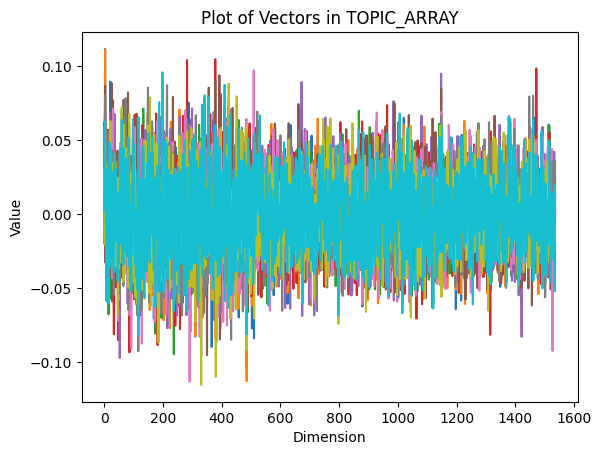

In [345]:
# Plot each vector in 'TOPIC_ARRAY'
for vector in TOPIC_ARRAY:
    plt.plot(vector)

plt.title('Plot of Vectors in TOPIC_ARRAY')
plt.xlabel('Dimension')
plt.ylabel('Value')
plt.show()

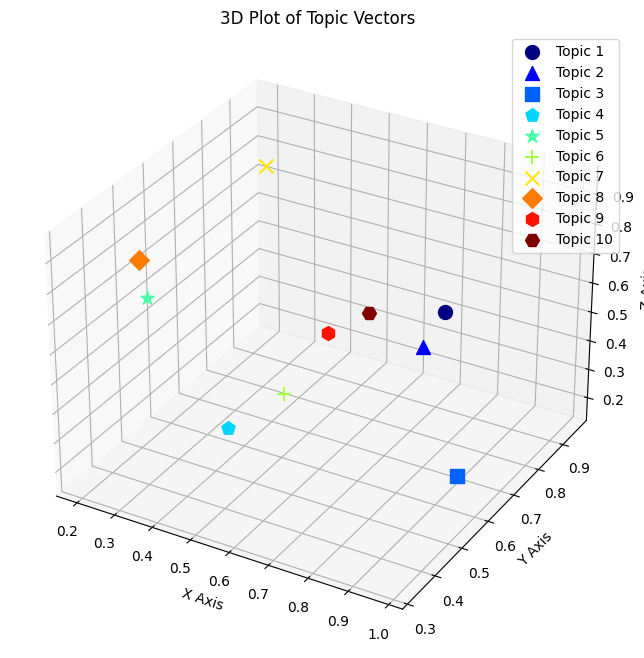

In [349]:
TOPIC_ARRAY = np.random.rand(10, 3)  # 10 vectors in 3D space

# Set up the figure and 3D subplot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Colors and markers can be customized as needed
colors = plt.cm.jet(np.linspace(0, 1, 10))
markers = ['o', '^', 's', 'p', '*', '+', 'x', 'D', 'h', 'H']

# Plot each vector from the NumPy array
for i, vector in enumerate(TOPIC_ARRAY):
    ax.scatter(vector[0], vector[1], vector[2], color=colors[i], marker=markers[i], s=100, label=f'Topic {i+1}')

# Labeling
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
plt.title('3D Plot of Topic Vectors')

# Legend
plt.legend()

plt.show()

### Single Vectors

#### Debate

In [141]:
client = OpenAI()

def get_embedding(text):
    # Make the API call to get embeddings
    response = client.embeddings.create(
        input=[text],  # Ensure input is correctly formatted
        model="text-embedding-3-small"  # Use the correct model identifier
    )
    # Convert the embedding to a numpy array before returning
    embedding_array = np.array(response.data[0].embedding)
    return embedding_array

# Fetch the embedding for "debate"
DEBATEV1 = get_embedding("debate")
print(DEBATEV1)

[0.03042204 0.0126825  0.0075922  ... 0.01453231 0.0080846  0.00855703]


In [ ]:
# Debate V2 based off of the following definition:
#Debate: In which the goal is to convince the other person and “win”.

#### Dialogue

In [143]:
client = OpenAI()

def get_embedding(text):
    # Make the API call to get embeddings
    response = client.embeddings.create(
        input=[text],  # Ensure input is correctly formatted
        model="text-embedding-3-small"  # Use the correct model identifier
    )
    # Convert the embedding to a numpy array before returning
    embedding_array = np.array(response.data[0].embedding)
    return embedding_array

# Fetch the embedding for "dialogue"
DIALOGUEV1 = get_embedding("dialogue")
print(DIALOGUEV1)

[ 0.0085625  -0.00239103 -0.01051011 ...  0.00585672  0.00358568
 -0.00335614]


In [ ]:
# Dialogue V2 based off of the following definition:
#Dialogue: In which the goal is to share and learn from each other.

#### Collaboration

In [144]:
client = OpenAI()

def get_embedding(text):
    # Make the API call to get embeddings
    response = client.embeddings.create(
        input=[text],  # Ensure input is correctly formatted
        model="text-embedding-3-small"  # Use the correct model identifier
    )
    # Convert the embedding to a numpy array before returning
    embedding_array = np.array(response.data[0].embedding)
    return embedding_array

# Fetch the embedding for "collaboration"
COLLABORATIONV1 = get_embedding("collaboration")
print(COLLABORATIONV1)

[ 0.02923005  0.00410742  0.07040898 ... -0.03149141 -0.01395896
 -0.00741919]


#### Competition

In [145]:
client = OpenAI()

def get_embedding(text):
    # Make the API call to get embeddings
    response = client.embeddings.create(
        input=[text],  # Ensure input is correctly formatted
        model="text-embedding-3-small"  # Use the correct model identifier
    )
    # Convert the embedding to a numpy array before returning
    embedding_array = np.array(response.data[0].embedding)
    return embedding_array

# Fetch the embedding for "competition"
COMPETITIONV1 = get_embedding("competition")
print(COMPETITIONV1)

[ 0.02851615 -0.01907052  0.05896278 ... -0.00339905  0.02282119
 -0.02206278]


## Cosine Similarities

In [153]:
# Calculate cosine similarity (1 - cosine distance)
cosine_similarity = 1 - cosine(DIALOGUEV1, DEBATEV1)
cosine_similarity


0.5961746612530533

In [155]:
# Calculate cosine similarity (1 - cosine distance)
cosine_similarity = 1 - cosine(COLLABORATIONV1, COMPETITIONV1)
cosine_similarity


0.3836860936920574

In [156]:
# Calculate cosine similarity (1 - cosine distance)
cosine_similarity = 1 - cosine(DIALOGUEV1, COLLABORATIONV1)
cosine_similarity


0.41987441908535406

In [162]:
# Calculate cosine similarity (1 - cosine distance)
cosine_similarity = 1 - cosine(DEBATEV1, COLLABORATIONV1)
cosine_similarity


0.32294655790719173

In [163]:
# Calculate cosine similarity (1 - cosine distance)
cosine_similarity = 1 - cosine(DIALOGUEV1, COMPETITIONV1)
cosine_similarity

0.3883272229832675

In [164]:
# Calculate cosine similarity (1 - cosine distance)
cosine_similarity = 1 - cosine(DEBATEV1, COMPETITIONV1)
cosine_similarity

0.43692643179820556

## Vizualizing Vectors

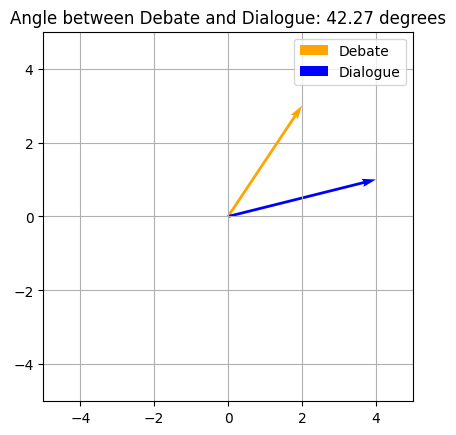

In [396]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Placeholder 2D vectors for "debate" and "dialogue"
# Replace these with your actual vectors reduced to their first two components
DEBATEV1 = np.array([2, 3])  # Example vector for "debate"
DIALOGUEV1 = np.array([4, 1])  # Example vector for "dialogue"

# Calculate the angle between them
cosine_angle = np.dot(DEBATEV1, DIALOGUEV1) / (np.linalg.norm(DEBATEV1) * np.linalg.norm(DIALOGUEV1))
angle = np.arccos(cosine_angle)

# Convert angle to degrees for easier interpretation
angle_degrees = np.degrees(angle)

# Plotting
fig, ax = plt.subplots()
ax.quiver(0, 0, DEBATEV1[0], DEBATEV1[1], angles='xy', scale_units='xy', scale=1, color='orange', label='Debate')
ax.quiver(0, 0, DIALOGUEV1[0], DIALOGUEV1[1], angles='xy', scale_units='xy', scale=1, color='b', label='Dialogue')

# Set the aspect of the plot to be equal, so the angle looks correct
ax.set_aspect('equal')

plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.grid(True)

# Display the angle in the title or legend
plt.title(f'Angle between Debate and Dialogue: {angle_degrees:.2f} degrees')

plt.legend()
plt.show()


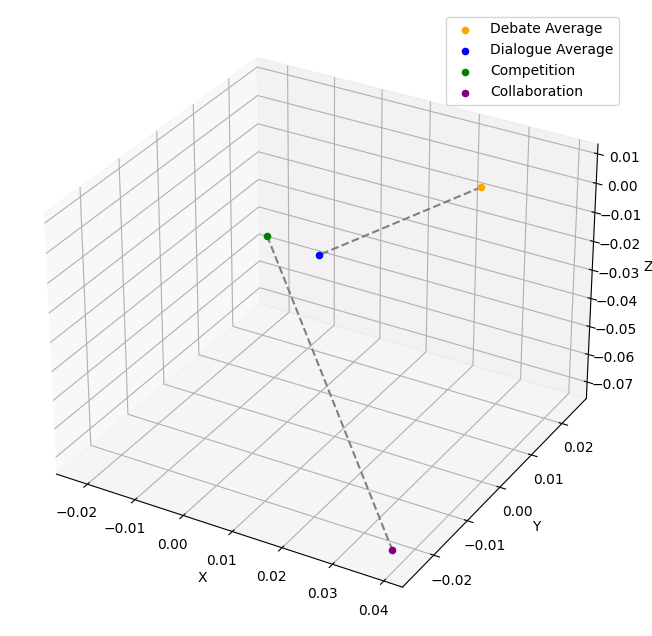

In [389]:
# Plot all vectors
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Assuming 'debate_vector' and 'dialogue_vector' are already defined from previous steps
# Plot average debate and dialogue vectors (first three components)
ax.scatter(DEBATEV1[0], DEBATEV1[1], DEBATEV1[2], c='orange', label='Debate Average')
ax.scatter(DIALOGUEV1[0], DIALOGUEV1[1], DIALOGUEV1[2], c='blue', label='Dialogue Average')

# Plot vectors for "competition" and "collaboration" (first three components)
ax.scatter(word_vectors[0][0], word_vectors[0][1], word_vectors[0][2], c='green', label='Competition')
ax.scatter(word_vectors[1][0], word_vectors[1][1], word_vectors[1][2], c='purple', label='Collaboration')

# Draw lines between debate-dialogue and competition-collaboration
# Debate to Dialogue
ax.plot([DEBATEV1[0], DIALOGUEV1[0]], [DEBATEV1[1], DIALOGUEV1[1]], [DEBATEV1[2], DIALOGUEV1[2]], 'gray', linestyle='--')
# Competition to Collaboration
ax.plot([word_vectors[0][0], word_vectors[1][0]], [word_vectors[0][1], word_vectors[1][1]], [word_vectors[0][2], word_vectors[1][2]], 'gray', linestyle='--')

# Add labels and legend
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')  # Corrected typo here
ax.legend()

plt.show()

### 3D Scatters

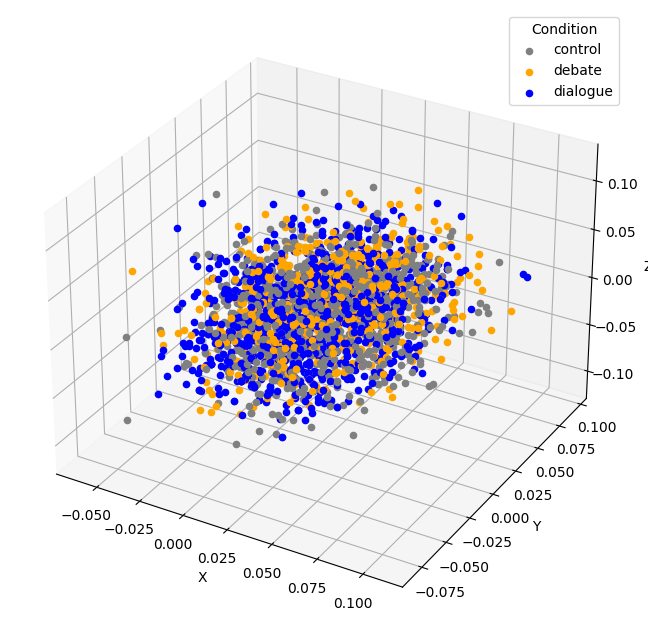

In [329]:
#Vizualizing by condition
color_dict = {'debate': 'orange', 'dialogue': 'blue'}

# Initialize the plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Iterate over rows in DataFrame and corresponding vectors in BOTH_ARRAY
for (index, row), vector in zip(BOTH_VECTORS.iterrows(), BOTH_ARRAY):
    # Initialize color as 'gray' for all vectors
    plot_color = 'gray'

    # Check conditions and adjust color if necessary
    if row['condition'] == 'debate' :
        plot_color = color_dict['debate']
    elif row['condition'] == 'dialogue' :
        plot_color = color_dict['dialogue']

    # Ensure the vector has at least 3 dimensions for 3D plotting
    if len(vector) >= 3:
        ax.scatter(vector[0], vector[1], vector[2], c=plot_color, label=row['condition'])

# Remove duplicate labels in the legend
handles, labels = ax.get_legend_handles_labels()
unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
ax.legend(*zip(*unique), title="Condition")

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()


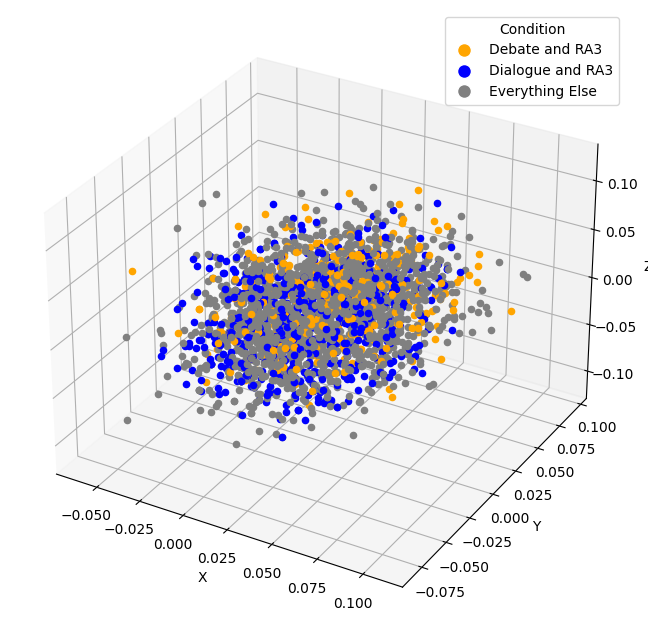

In [334]:
# Define colors for each condition we want to plot, including the default 'control'
color_dict = {'debate': 'orange', 'dialogue': 'blue', 'control': 'gray'}

# Initialize the plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Iterate over rows in DataFrame and corresponding vectors
for (index, row), vector in zip(BOTH_VECTORS.iterrows(), BOTH_ARRAY):
    # Set default color for 'control'
    plot_color = color_dict['control']

    # Adjust color if conditions meet specific criteria
    if row['condition'] == 'debate' and row['debate_rating'] == 3:
        plot_color = color_dict['debate']
    elif row['condition'] == 'dialogue' and row['dialogue_rating'] == 3:
        plot_color = color_dict['dialogue']

    # Plot each vector with the determined color
    if len(vector) >= 3:  # Ensure vector has at least 3 dimensions
        ax.scatter(vector[0], vector[1], vector[2], c=plot_color)

# Create custom legends
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Debate and RA3',
                          markerfacecolor=color_dict['debate'], markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Dialogue and RA3',
                          markerfacecolor=color_dict['dialogue'], markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Everything Else',
                          markerfacecolor=color_dict['control'], markersize=10)]

# Add the custom legend to the plot
ax.legend(handles=legend_elements, title="Condition")

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

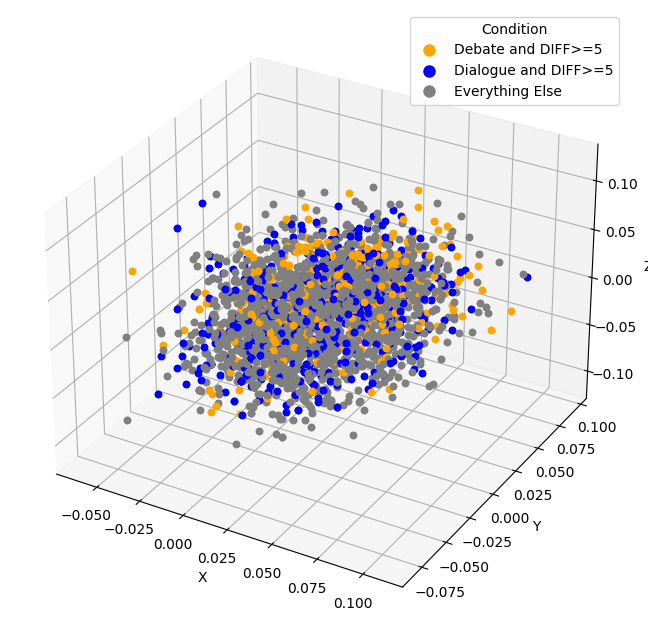

In [335]:
# Define colors for each condition we want to plot, including the default 'control'
color_dict = {'debate': 'orange', 'dialogue': 'blue', 'control': 'gray'}

# Initialize the plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Iterate over rows in DataFrame and corresponding vectors
for (index, row), vector in zip(BOTH_VECTORS.iterrows(), BOTH_ARRAY):
    # Set default color for 'control'
    plot_color = color_dict['control']

    # Check conditions and adjust color if "diff" is 5 or greater
    if row['diff'] >= 5:
        if row['condition'] == 'debate':
            plot_color = color_dict['debate']
        elif row['condition'] == 'dialogue':
            plot_color = color_dict['dialogue']

    # Ensure the vector has at least 3 dimensions for 3D plotting
    if len(vector) >= 3:
        ax.scatter(vector[0], vector[1], vector[2], c=plot_color, label=row['condition'] if row['diff'] >= 5 else '')

    # Plot each vector with the determined color
    if len(vector) >= 3:  # Ensure vector has at least 3 dimensions
        ax.scatter(vector[0], vector[1], vector[2], c=plot_color)

# Create custom legends
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Debate and DIFF>=5',
                          markerfacecolor=color_dict['debate'], markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Dialogue and DIFF>=5',
                          markerfacecolor=color_dict['dialogue'], markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Everything Else',
                          markerfacecolor=color_dict['control'], markersize=10)]

# Add the custom legend to the plot
ax.legend(handles=legend_elements, title="Condition")

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

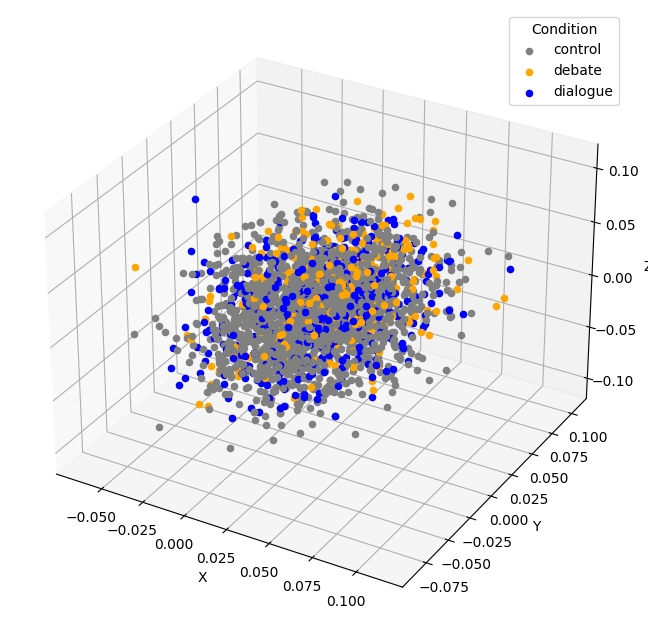

In [100]:
# Define colors for each condition we want to plot, but only highlight if "diff" >= 5
color_dict = {'debate': 'orange', 'dialogue': 'blue'}

# Initialize the plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Iterate over rows in DataFrame and corresponding vectors in LEM_ARRAY
for (index, row), vector in zip(LEM_VECTORS.iterrows(), LEM_ARRAY):
    # Initialize color as 'gray' for all vectors not meeting the "diff" condition
    plot_color = 'gray'

    # Check conditions and adjust color if "diff" is 5 or greater
    if row['diff'] >= 5:
        if row['condition'] == 'debate':
            plot_color = color_dict['debate']
        elif row['condition'] == 'dialogue':
            plot_color = color_dict['dialogue']

    # Ensure the vector has at least 3 dimensions for 3D plotting
    if len(vector) >= 3:
        ax.scatter(vector[0], vector[1], vector[2], c=plot_color, label=row['condition'] if row['diff'] >= 5 else '')

# Remove duplicate labels in the legend and empty labels
handles, labels = ax.get_legend_handles_labels()
unique_labels = []
unique_handles = []
for handle, label in zip(handles, labels):
    if label and label not in unique_labels:
        unique_labels.append(label)
        unique_handles.append(handle)
if unique_labels:  # Only add the legend if there are labels to display
    ax.legend(unique_handles, unique_labels, title="Condition")

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()


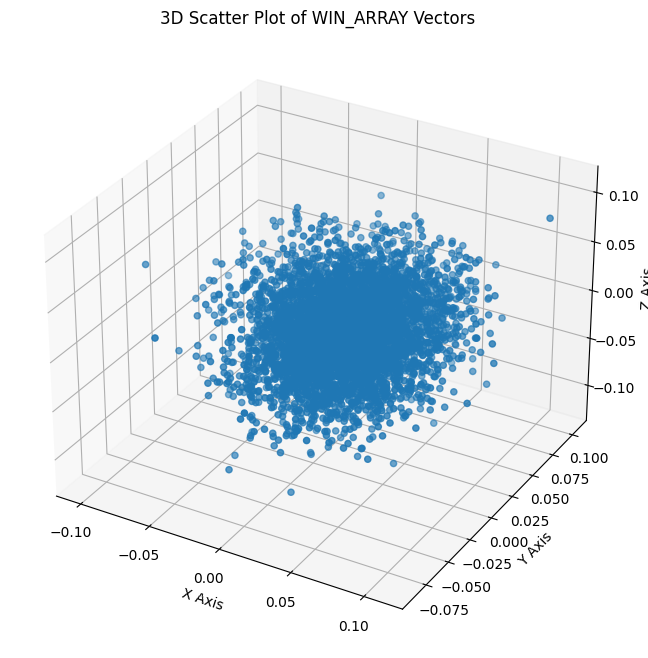

In [371]:
#WINNING SCATTER
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of the vectors
ax.scatter(WIN_ARRAY[:, 0], WIN_ARRAY[:, 1], WIN_ARRAY[:, 2])

# Labeling
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
plt.title('3D Scatter Plot of WIN_ARRAY Vectors')

plt.show()

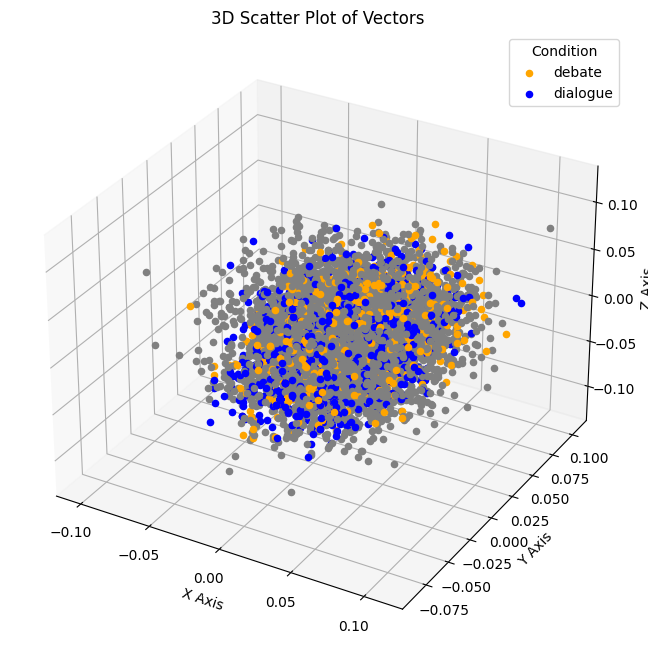

In [372]:
#winning and both
# Initialize color mapping for conditions
color_dict = {'debate': 'orange', 'dialogue': 'blue'}

# Set up the figure for 3D plotting
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot all vectors in WIN_ARRAY as gray
for vector in WIN_ARRAY:
    if len(vector) >= 3:  # Ensure the vector has at least 3 dimensions for 3D plotting
        ax.scatter(vector[0], vector[1], vector[2], c='gray')

# Plot vectors from BOTH_ARRAY when the condition is either 'debate' or 'dialogue'
for (index, row), vector in zip(BOTH_VECTORS.iterrows(), BOTH_ARRAY):
    if row['condition'] in ['debate', 'dialogue']:
        plot_color = color_dict[row['condition']]
        if len(vector) >= 3:
            ax.scatter(vector[0], vector[1], vector[2], c=plot_color, label=row['condition'])

# Since plotting with labels in a loop can create duplicates in the legend, filter them out
handles, labels = ax.get_legend_handles_labels()
unique_labels = list(dict.fromkeys(labels))
unique_handles = [handles[labels.index(label)] for label in unique_labels]
ax.legend(unique_handles, unique_labels, title="Condition")

# Set axis labels and the plot title
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
plt.title('3D Scatter Plot of Vectors')

plt.show()


### TOPIC VIZ

In [356]:
print(TOPICS['TOPIC'])

0    Men have too much privilege in the United Stat...
1    White people have too much privilege in the Un...
2    Republican party politicians are taking this c...
3    Gun control laws should be stricter than they ...
4    Women should show solidarity by preferentially...
5    Access to abortions should be restricted as mu...
6    Affirmative action is giving unfair advantages...
7    Older people these days are too insensitive an...
8    Younger people these days are too quick to jud...
9    Democratic party politicians are taking this c...
Name: TOPIC, dtype: object


In [357]:
topics = TOPICS['TOPIC'].tolist()
topic_labels = []

# Loop through topics and label them
for i, topic in enumerate(topics):
    topic_labels.append(f'Topic {i + 1}')

# Add a new column with the labeled topics
TOPICS['TOPIC#'] = topic_labels

# Display the DataFrame
print(TOPICS)

                                               TOPIC  \
0  Men have too much privilege in the United Stat...   
1  White people have too much privilege in the Un...   
2  Republican party politicians are taking this c...   
3  Gun control laws should be stricter than they ...   
4  Women should show solidarity by preferentially...   
5  Access to abortions should be restricted as mu...   
6  Affirmative action is giving unfair advantages...   
7  Older people these days are too insensitive an...   
8  Younger people these days are too quick to jud...   
9  Democratic party politicians are taking this c...   

                                       TOPIC_VECTORS    TOPIC#  
0  [0.04595646262168884, 0.04933732748031616, 0.0...   Topic 1  
1  [0.04733336716890335, 0.0363675057888031, 0.01...   Topic 2  
2  [0.0010742234298959374, 0.016037592664361, 0.0...   Topic 3  
3  [0.028451167047023773, 0.04059121012687683, 0....   Topic 4  
4  [-0.0062978845089674, 0.009168485179543495, 0....   Top

In [358]:
# Create a new column 'TOPIC#' in TURNS DataFrame
TURNS['TOPIC#'] = ''

# Loop through 'chosen_topic' in TURNS DataFrame
for index, row in TURNS.iterrows():
    chosen_topic = row['chosen_topic']

    # Find the index of matching 'TOPIC' in TOPICS DataFrame
    topic_index = TOPICS.index[TOPICS['TOPIC'] == chosen_topic].tolist()

    # If matching 'TOPIC' found, copy corresponding 'TOPIC#' to 'TOPIC#' column in TURNS DataFrame
    if topic_index:
        topic_number = TOPICS.loc[topic_index[0], 'TOPIC#']
        TURNS.at[index, 'TOPIC#'] = topic_number

# Display the updated TURNS DataFrame
print(TURNS['TOPIC#'])

0       Topic 1
1       Topic 1
2       Topic 1
3       Topic 1
4       Topic 1
         ...   
2676    Topic 3
2677    Topic 3
2678    Topic 3
2679    Topic 3
2680    Topic 3
Name: TOPIC#, Length: 2681, dtype: object


In [360]:
BOTH_VECTORS['TOPIC#'] = TURNS['TOPIC#'].values

<ipython-input-397-30881891a4bc>:26: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(vector[0], vector[1], vector[2], c=color, marker=marker, label=topic_label)


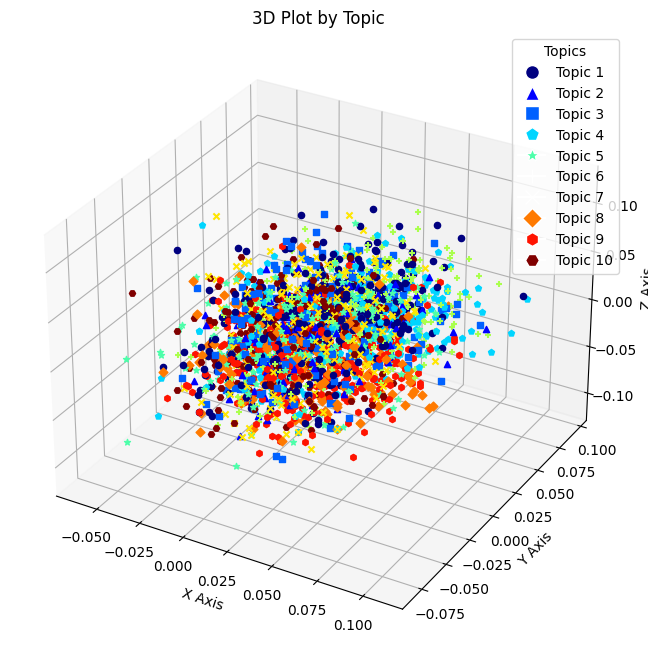

In [397]:
# Set up the figure and 3D subplot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Predefined colors and markers for each topic
colors = plt.cm.jet(np.linspace(0, 1, 10))
markers = ['o', '^', 's', 'p', '*', '+', 'x', 'D', 'h', 'H']

# Mapping of topic numbers to colors and markers
topic_color_marker_map = {f'Topic {i+1}': (colors[i], markers[i]) for i in range(10)}

# Iterate over rows in DataFrame and corresponding vectors in BOTH_ARRAY
for (index, row), vector in zip(BOTH_VECTORS.iterrows(), BOTH_ARRAY):
    # Make sure the topic label is constructed correctly
    # If "TOPIC#" directly contains the topic number without the word "Topic"
    #topic_number = row["TOPIC#"]  # Directly using the topic number
    #topic_label = f'Topic {topic_number}"  # Constructing the label

    # Alternatively, if "TOPIC#" contains the full label like "Topic 1", use it directly:
    topic_label = row["TOPIC#"]

    color, marker = topic_color_marker_map[topic_label]

    # Plot the vector with the assigned color and marker
    if len(vector) >= 3:  # Ensure the vector has at least 3 dimensions
        ax.scatter(vector[0], vector[1], vector[2], c=color, marker=marker, label=topic_label)

# To avoid duplicate labels in the legend, we'll update the approach:
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker=marker, color='w', markerfacecolor=color, label=label, markersize=10)
                   for label, (color, marker) in topic_color_marker_map.items()]
ax.legend(handles=legend_elements, title="Topics")

# Set axis labels
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
plt.title('3D Plot by Topic')

plt.show()


###Viz 1

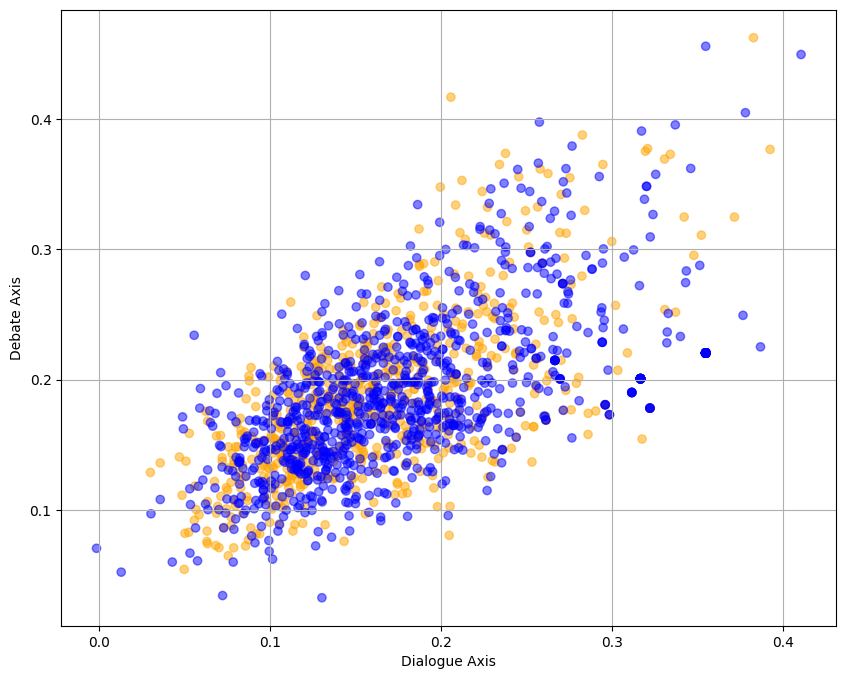

In [149]:
# Normalize the 'dialogue' and 'debate' vectors to unit vectors
dialogue_vector = DIALOGUEV1 / np.linalg.norm(DIALOGUEV1)
debate_vector = DEBATEV1 / np.linalg.norm(DEBATEV1)

# Initialize lists to hold the projected coordinates
dialogue_projection = []
debate_projection = []
colors = []  # To store the color of each point

# Define your color mapping
color_dict = {'debate': 'orange', 'dialogue': 'blue'}

# Iterate over the DataFrame and corresponding vectors
for condition, vector in zip(LEM_VECTORS['condition'], LEM_ARRAY):
    if condition in ['debate', 'dialogue']:
        # Project the vector onto the 'dialogue' and 'debate' vectors
        dialogue_proj = np.dot(vector, dialogue_vector)
        debate_proj = np.dot(vector, debate_vector)

        # Add the projections and color to their respective lists
        dialogue_projection.append(dialogue_proj)
        debate_projection.append(debate_proj)
        colors.append(color_dict[condition])

# Now create the plot
plt.figure(figsize=(10, 8))

# Plot each point in the 2D space
plt.scatter(dialogue_projection, debate_projection, alpha=0.5, c=colors)

# Setting the labels for the axes
plt.xlabel('Dialogue Axis')
plt.ylabel('Debate Axis')

# Show the plot with a grid
plt.grid(True)
plt.show()


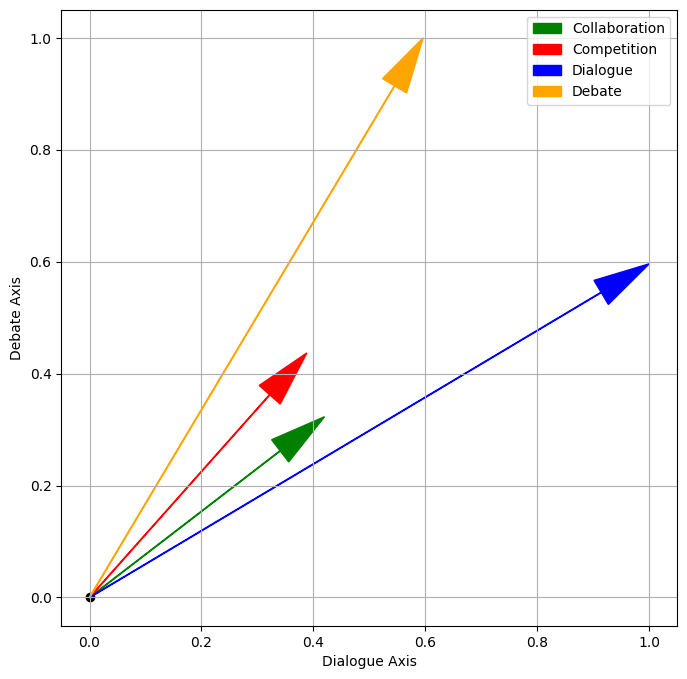

In [362]:
# Normalize the 'dialogue' and 'debate' vectors to unit vectors
dialogue_vector = DIALOGUEV1 / np.linalg.norm(DIALOGUEV1)
debate_vector = DEBATEV1 / np.linalg.norm(DEBATEV1)

# Initialize the plot
plt.figure(figsize=(10, 8))
ax = plt.gca()

# Plot the origin
ax.scatter(0, 0, color='k')

# Function to project and plot vectors
def project_and_plot(vector, color, label):
    # Project the vector onto the 'dialogue' and 'debate' vectors
    dialogue_proj = np.dot(vector, dialogue_vector)
    debate_proj = np.dot(vector, debate_vector)

    # Plot the arrow
    ax.arrow(0, 0, dialogue_proj, debate_proj,
             head_width=0.05, head_length=0.1, fc=color, ec=color, length_includes_head=True, label=label)

# Plot the 'collaboration' vector
project_and_plot(COLLABORATIONV1, 'green', 'Collaboration')

# Plot the 'competition' vector
project_and_plot(COMPETITIONV1, 'red', 'Competition')

# Setting the labels for the axes
ax.set_xlabel('Dialogue Axis')
ax.set_ylabel('Debate Axis')

# Setting the aspect ratio of the plot to be equal
ax.set_aspect('equal')

# Plotting the original 'dialogue' and 'debate' vectors for reference
project_and_plot(dialogue_vector, 'blue', 'Dialogue')
project_and_plot(debate_vector, 'orange', 'Debate')

# Adding a legend to the plot
ax.legend()

# Show the plot with a grid
plt.grid(True)
plt.show()


In [366]:
import numpy as np

def procrustes(X, Y, scaling=True, reflection='best'):
    """
    A function for Procrustes analysis which allows for scaling, translation,
    and rotation of a matrix of points Y to best conform to a matrix X.

    Parameters:
    - X: ndarray, shape (m, n). Matrix of target points.
    - Y: ndarray, shape (m, n). Matrix of input points to be fitted to X.
    - scaling: bool, whether to allow scaling.
    - reflection: str, 'best' (default) allows for reflecting the matrix Y.
                  Use 'no' to disable reflection.

    Returns:
    - d: float, the squared distance between X and the optimal alignment of Y.
    - Z: ndarray, the matrix of Y aligned to X.
    - T: ndarray, the translation vector applied to Y.
    - b: float, the scaling applied to Y.
    - R: ndarray, the rotation matrix applied to Y.
    """
    # Ensure correct shape and float type
    X = np.asarray(X, dtype=np.float64)
    Y = np.asarray(Y, dtype=np.float64)

    # Centering
    X0 = X - X.mean(axis=0)
    Y0 = Y - Y.mean(axis=0)

    # Scaling
    if scaling:
        normX = np.linalg.norm(X0)
        normY = np.linalg.norm(Y0)
        Y0 *= normX / normY
        d = 1.0
    else:
        d = np.linalg.norm(X0) ** 2 + np.linalg.norm(Y0) ** 2

    # SVD for rotation
    A = np.dot(X0.T, Y0)
    U, s, Vt = np.linalg.svd(A, full_matrices=False)
    V = Vt.T
    T = np.dot(V, U.T)

    if reflection not in ['best', 'no']:
        raise ValueError("reflection must be 'best' or 'no'.")

    if reflection == 'best':
        if np.linalg.det(T) < 0:
            V[:, -1] *= -1
            s[-1] *= -1
            T = np.dot(V, U.T)

    traceTA = s.sum()

    if scaling:
        b = traceTA * normX / d
        d = 1 - traceTA ** 2
    else:
        b = 1
        d = 1 + d - 2 * traceTA * normY / normX

    Z = normX * np.dot(Y0, T) / d + X.mean(axis=0)
    return d, Z, X.mean(axis=0) - Z.mean(axis=0), b, T


## Centroids

In [ ]:
# Calculate the centroid of WIN_ARRAY
centroid_WIN_ARRAY = np.mean(WIN_ARRAY, axis=0)

# Calculate the centroid of BOTH_ARRAY
centroid_BOTH_ARRAY = np.mean(BOTH_ARRAY, axis=0)

# Print the centroids
print(f"Centroid of WIN_ARRAY: {centroid_WIN_ARRAY}")
print(f"Centroid of BOTH_ARRAY: {centroid_BOTH_ARRAY}")

Centroid of WIN_ARRAY: [ 0.01617687  0.01139883 -0.00320305 ...  0.00475903 -0.00266564
  0.00875699]
Centroid of BOTH_ARRAY: [ 0.02056698 -0.00045439  0.00189176 ... -0.00032628 -0.01883957
  0.00560941]


In [ ]:
# Convert BOTH_ARRAY to a DataFrame for easier filtering, if it's not already one
BOTH_ARRAY_DF = pd.DataFrame(BOTH_ARRAY)

# Filter vectors where condition is 'debate'
debate_vectors = BOTH_ARRAY_DF[BOTH_VECTORS['condition'] == 'debate'].values

# Filter vectors where condition is 'dialogue'
dialogue_vectors = BOTH_ARRAY_DF[BOTH_VECTORS['condition'] == 'dialogue'].values

# Calculate the centroid for debate vectors
centroid_debate = np.mean(debate_vectors, axis=0)

# Calculate the centroid for dialogue vectors
centroid_dialogue = np.mean(dialogue_vectors, axis=0)

# Print the centroids
print(f"Centroid for 'debate' condition: {centroid_debate}")
print(f"Centroid for 'dialogue' condition: {centroid_dialogue}")

Centroid for 'debate' condition: [ 0.0228285   0.00389859  0.00748124 ... -0.00028926 -0.01809978
  0.00565196]
Centroid for 'dialogue' condition: [ 1.83848048e-02 -2.84707569e-03  2.31582048e-04 ...  4.46833917e-05
 -1.98484644e-02  4.48345821e-03]


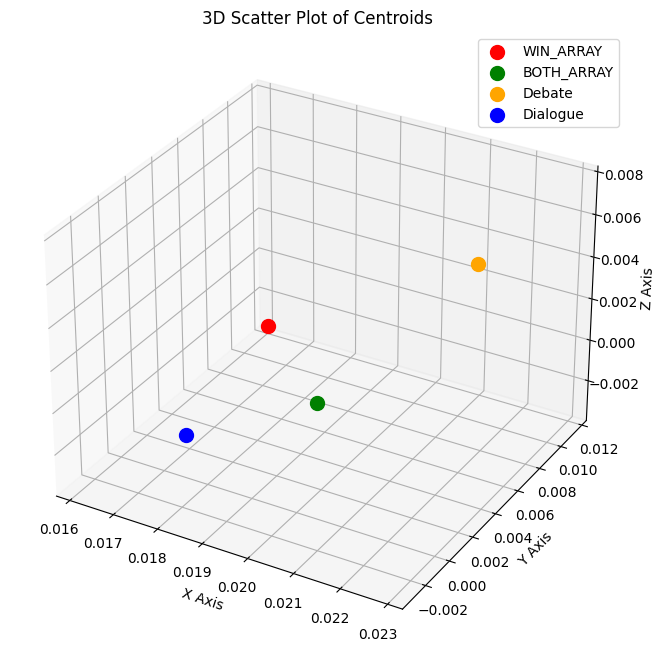

In [378]:
centroids = np.array([centroid_WIN_ARRAY, centroid_BOTH_ARRAY, centroid_debate, centroid_dialogue])
centroid_labels = ['WIN_ARRAY', 'BOTH_ARRAY', 'Debate', 'Dialogue']
colors = ['red', 'green', 'orange', 'blue']

# Set up the figure and 3D subplot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot each centroid
for i, centroid in enumerate(centroids):
    ax.scatter(centroid[0], centroid[1], centroid[2], color=colors[i], s=100, label=centroid_labels[i])

# Legend and labels
ax.legend()
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
plt.title('3D Scatter Plot of Centroids')

plt.show()


In [380]:
# Function to calculate cosine similarity
def calculate_cosine_similarity(v1, v2):
    # Reshape vectors to 2D arrays
    v1_reshaped = v1.reshape(1, -1)
    v2_reshaped = v2.reshape(1, -1)
    # Calculate cosine similarity and then subtract from 1 to get the cosine difference
    cosine_diff = 1 - cosine_similarity(v1_reshaped, v2_reshaped)
    return cosine_diff[0][0]

# Pairwise comparison of centroids
centroid_names = ['WIN_ARRAY', 'BOTH_ARRAY', 'Debate', 'Dialogue']
for i in range(len(centroids)):
    for j in range(i+1, len(centroids)):
        cosine_diff = calculate_cosine_similarity(centroids[i], centroids[j])
        print(f"Cosine difference between {centroid_names[i]} and {centroid_names[j]}: {cosine_diff}")


Cosine difference between WIN_ARRAY and BOTH_ARRAY: 0.2281932885009328
Cosine difference between WIN_ARRAY and Debate: 0.23865016851937448
Cosine difference between WIN_ARRAY and Dialogue: 0.2267019498065601
Cosine difference between BOTH_ARRAY and Debate: 0.007119265416859144
Cosine difference between BOTH_ARRAY and Dialogue: 0.003436777377553102
Cosine difference between Debate and Dialogue: 0.016020637070170318


In [ ]:
# Function to calculate cosine similarity
def calculate_cosine_similarity(v1, v2):
    # Reshape vectors to 2D arrays
    v1_reshaped = v1.reshape(1, -1)
    v2_reshaped = v2.reshape(1, -1)
    # Calculate cosine similarity and then subtract from 1 to get the cosine difference
    cosine_diff = 1 - cosine_similarity(v1_reshaped, v2_reshaped)
    return cosine_diff[0][0]

# Pairwise comparison of centroids
centroid_names = ['WIN_ARRAY', 'BOTH_ARRAY', 'Debate', 'Dialogue']
for i in range(len(centroids)):
    for j in range(i+1, len(centroids)):
        cosine_diff = calculate_cosine_similarity(centroids[i], centroids[j])
        print(f"Cosine difference between {centroid_names[i]} and {centroid_names[j]}: {cosine_diff}")


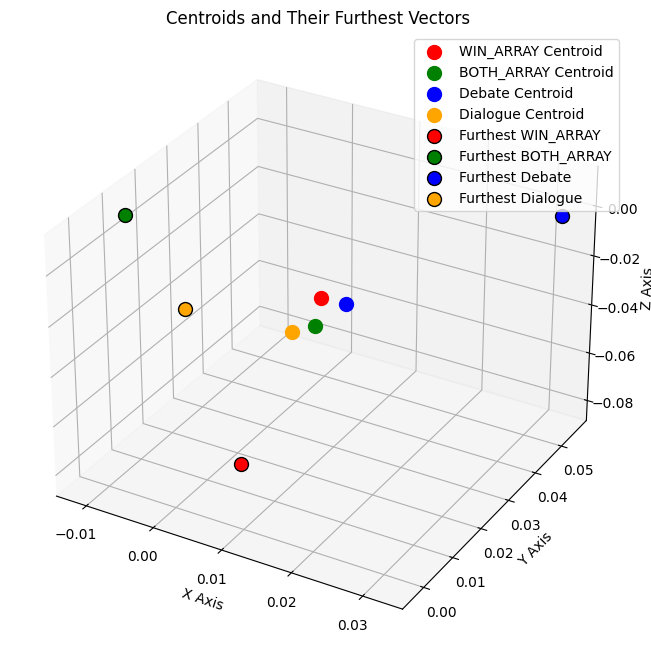

In [399]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Setup for plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Assuming centroids and furthest_vectors are lists of np.array or similar iterable with shape (3,)
# and each contains [x, y, z] coordinates
centroid_labels = ['WIN_ARRAY Centroid', 'BOTH_ARRAY Centroid', 'Debate Centroid', 'Dialogue Centroid']
furthest_vector_labels = ['Furthest WIN_ARRAY', 'Furthest BOTH_ARRAY', 'Furthest Debate', 'Furthest Dialogue']
colors = ['red', 'green', 'blue', 'orange']  # Example colors

# Plot centroids
for i, centroid in enumerate(centroids):
    ax.scatter(centroid[0], centroid[1], centroid[2], color=colors[i], s=100, label=centroid_labels[i])

# Assuming furthest_vectors is a list of the furthest vector for each category
for i, vector in enumerate(furthest_vectors):
    ax.scatter(vector[0], vector[1], vector[2], color=colors[i], s=100, edgecolor='k', label=furthest_vector_labels[i])

# Enhance plot
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
plt.title('Centroids and Their Furthest Vectors')
plt.legend()
plt.show()


In [400]:
# Reshape the vectors for cosine similarity calculation (from (3,) to (1, 3))
reshaped_centroids = [centroid.reshape(1, -1) for centroid in centroids]
reshaped_furthest_vectors = [vector.reshape(1, -1) for vector in furthest_vectors]

# Calculate and print cosine similarity for each pair
cosine_similarities = []

for centroid, furthest_vector, label in zip(reshaped_centroids, reshaped_furthest_vectors, centroid_labels):
    similarity = cosine_similarity(centroid, furthest_vector)[0][0]
    cosine_similarities.append(similarity)
    print(f"Cosine similarity for {label}: {similarity:.4f}")

Cosine similarity for WIN_ARRAY Centroid: 0.1105
Cosine similarity for BOTH_ARRAY Centroid: 0.1772
Cosine similarity for Debate Centroid: 0.2393
Cosine similarity for Dialogue Centroid: 0.2101


In [404]:
furthest_vector_WIN, _ = find_furthest_vector(WIN_ARRAY, centroid_WIN_ARRAY)
furthest_vector_BOTH, _ = find_furthest_vector(BOTH_ARRAY, centroid_BOTH_ARRAY)

# Assuming debate_vectors and dialogue_vectors are arrays of vectors for 'debate' and 'dialogue' conditions
furthest_vector_debate, _ = find_furthest_vector(debate_vectors, centroid_debate)
furthest_vector_dialogue, _ = find_furthest_vector(dialogue_vectors, centroid_dialogue)


In [405]:
# Example for WIN_ARRAY
std_devs_away_WIN, std_dev_WIN, furthest_distance_WIN = calculate_std_dev_away(WIN_ARRAY, centroid_WIN_ARRAY, furthest_vector_WIN)
print(f"WIN_ARRAY: Furthest vector is {std_devs_away_WIN:.2f} standard deviations away from the centroid.")

# Repeat for BOTH_ARRAY, debate_vectors, and dialogue_vectors
std_devs_away_BOTH, std_dev_BOTH, furthest_distance_BOTH = calculate_std_dev_away(BOTH_ARRAY, centroid_BOTH_ARRAY, furthest_vector_BOTH)
print(f"BOTH_ARRAY: Furthest vector is {std_devs_away_BOTH:.2f} standard deviations away from the centroid.")

std_devs_away_debate, std_dev_debate, furthest_distance_debate = calculate_std_dev_away(debate_vectors, centroid_debate, furthest_vector_debate)
print(f"Debate: Furthest vector is {std_devs_away_debate:.2f} standard deviations away from the centroid.")

std_devs_away_dialogue, std_dev_dialogue, furthest_distance_dialogue = calculate_std_dev_away(dialogue_vectors, centroid_dialogue, furthest_vector_dialogue)
print(f"Dialogue: Furthest vector is {std_devs_away_dialogue:.2f} standard deviations away from the centroid.")


WIN_ARRAY: Furthest vector is 24.48 standard deviations away from the centroid.
BOTH_ARRAY: Furthest vector is 30.79 standard deviations away from the centroid.
Debate: Furthest vector is 31.19 standard deviations away from the centroid.
Dialogue: Furthest vector is 28.91 standard deviations away from the centroid.


# SD Calculations

In [406]:
mean_duration = TURNS['Duration (in seconds)'].mean()
std_deviation = TURNS['Duration (in seconds)'].std()

print(f"Mean duration: {mean_duration:.2f} seconds")
print(f"Standard deviation: {std_deviation:.2f} seconds")

Mean duration: 1077.19 seconds
Standard deviation: 173.15 seconds
